## Práctica 3 Parte B

### Alumno: Zhengkai Zhu

In [1]:
import sys
print(sys.version)

3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


In [2]:
import numpy as np
import math

## Import Qiskit
##from qiskit import QuantumCircuit, QuantumRegister
##from qiskit import Aer, transpile
##from qiskit.providers.aer import Aer, AerSimulator
##from qiskit.providers.fake_provider import FakeVigo

##from qiskit.visualization import array_to_latex
##from qiskit.tools.visualization import plot_histogram, plot_state_city
##import qiskit.quantum_info as qi



# nuevo Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings("ignore")

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram, plot_state_city, array_to_latex # plot_histogram is already imported earlier in the code, you can remove it from here if you want
import qiskit.quantum_info as qi
from qiskit.providers.fake_provider import GenericBackendV2
#from qiskit.providers.fake_provider import FakeLima

## Ejercicio 1
(Las expliaciones detalladas del ejercicio están al final del mismo)

Implementar la QFT y la AQFT con 2 rotaciones como másximo

Para empezar voy a copiar la funcion para crear una QFT de n qubits de la parte A de la práctica

In [3]:
def qft_n_qubits(circuit, n, swaps = True, barrier = True):
    
    for i in range(n - 1, -1, -1): #Empezamos por el mas significativo
        circuit.h(circuit.qubits[i])
        for j in range(i - 1, -1, -1):
            circuit.cp(math.pi/2**(i - j), circuit.qubits[j], circuit.qubits[i])
        if barrier:
            circuit.barrier()
      
    if swaps:   
        #Al final del todo agregamos los Swaps 
        for i in range(n//2):
            circuit.swap(circuit.qubits[i], circuit.qubits[n - 1 - i])
    
    return circuit

A continuacion voy a crear una funcion que dado un circuito, n qubits un m de maximo de rotaciones, implemente una AQFT de n qubits y como máximo m rotaciones.

In [4]:
def aqft_NM(circuit, n, m, swaps = True, barrier = True):
    
    for i in range(n - 1, -1, -1): #Empezamos por el mas significativo
        circuit.h(circuit.qubits[i])
        k = 0
        j = i - 1
        while j >= 0 and k < m:
            circuit.cp(math.pi/2**(i - j), circuit.qubits[j], circuit.qubits[i])
            j = j - 1
            k = k + 1
        if barrier:
            circuit.barrier()
    
    if swaps:     
        #Al final del todo agregamos los Swaps 
        for i in range(n//2):
            circuit.swap(circuit.qubits[i], circuit.qubits[n - 1 - i])
    
    return circuit

Para la implementacion de la AQFT que se nos pide he reutilizado la funcion para crear la QFT de n qubits. Solo tengo que cambiar el bucle $for$ interno para añadir las rotaciones de fase controladas.\
A ese bucle lo he cambiado por un $while$ de forma añado otra condicion más al del $for$ y es que el numero de cp() no supere m.

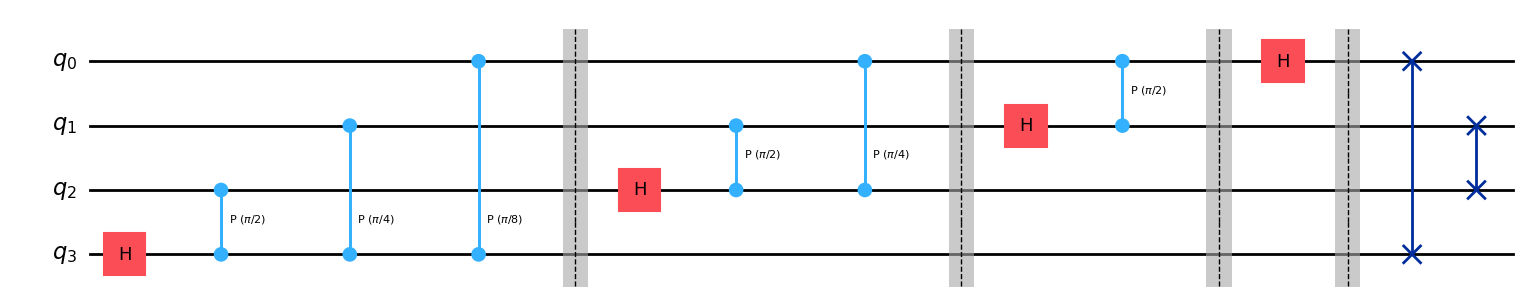

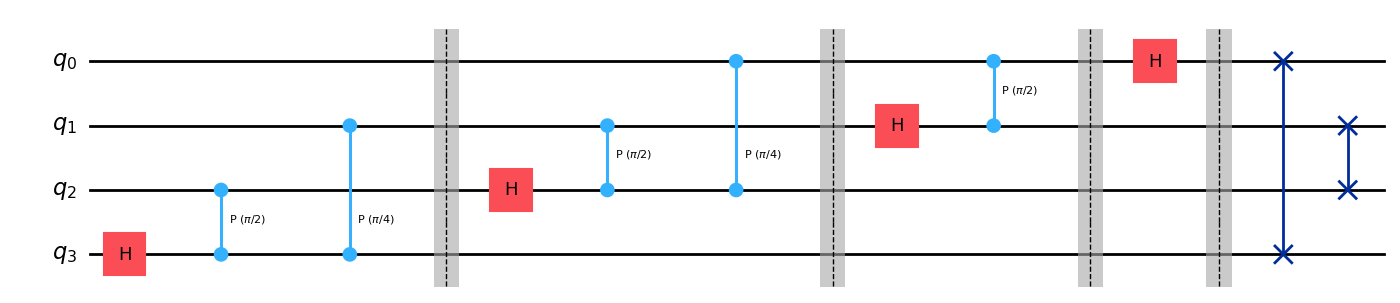

In [5]:
qft4b = qft_n_qubits(QuantumCircuit(4),4)
aqft4b = aqft_NM(QuantumCircuit(4), 4, 2)

display(qft4b.draw('mpl'))
display(aqft4b.draw('mpl'))

##### Pruebas y comprobación de funcionamiento

A continuación para probar que funciona, voy a utilizar las señales que se ha implementado en la parte A de la práctica.
Voy a simular el funcionamiento con el QASM_Simulator de Aer, que me permite mostrar el histograma de medidas tras varios shots

In [6]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile, assemble
import numpy as np

def crear_señal(which_signal):
    #creamos un registro cuántico donde almacenaremos una señal periódica A, B o C
    #codificamos esa periodicidad en la fase de los qbits del registro
    signal = QuantumRegister(4, name='s')
    qc = QuantumCircuit(signal)

    ## preparamos las señales
    qc.h(signal)
    if which_signal == 'A':
        qc.rz(math.radians(180), signal[0])
    elif which_signal == 'B':
        qc.rz(math.radians(-90), signal[0])
        qc.rz(math.radians(180), signal[1])
    elif which_signal == 'C':
        qc.rz(math.radians(-45), signal[0])
        qc.rz(math.radians(-90), signal[1])
        qc.rz(math.radians(180), signal[2])

    qc.barrier()
    return qc
#display(qc.draw(output='mpl'))  # Visualizar con Matplotlib

Pruebo con la señal A

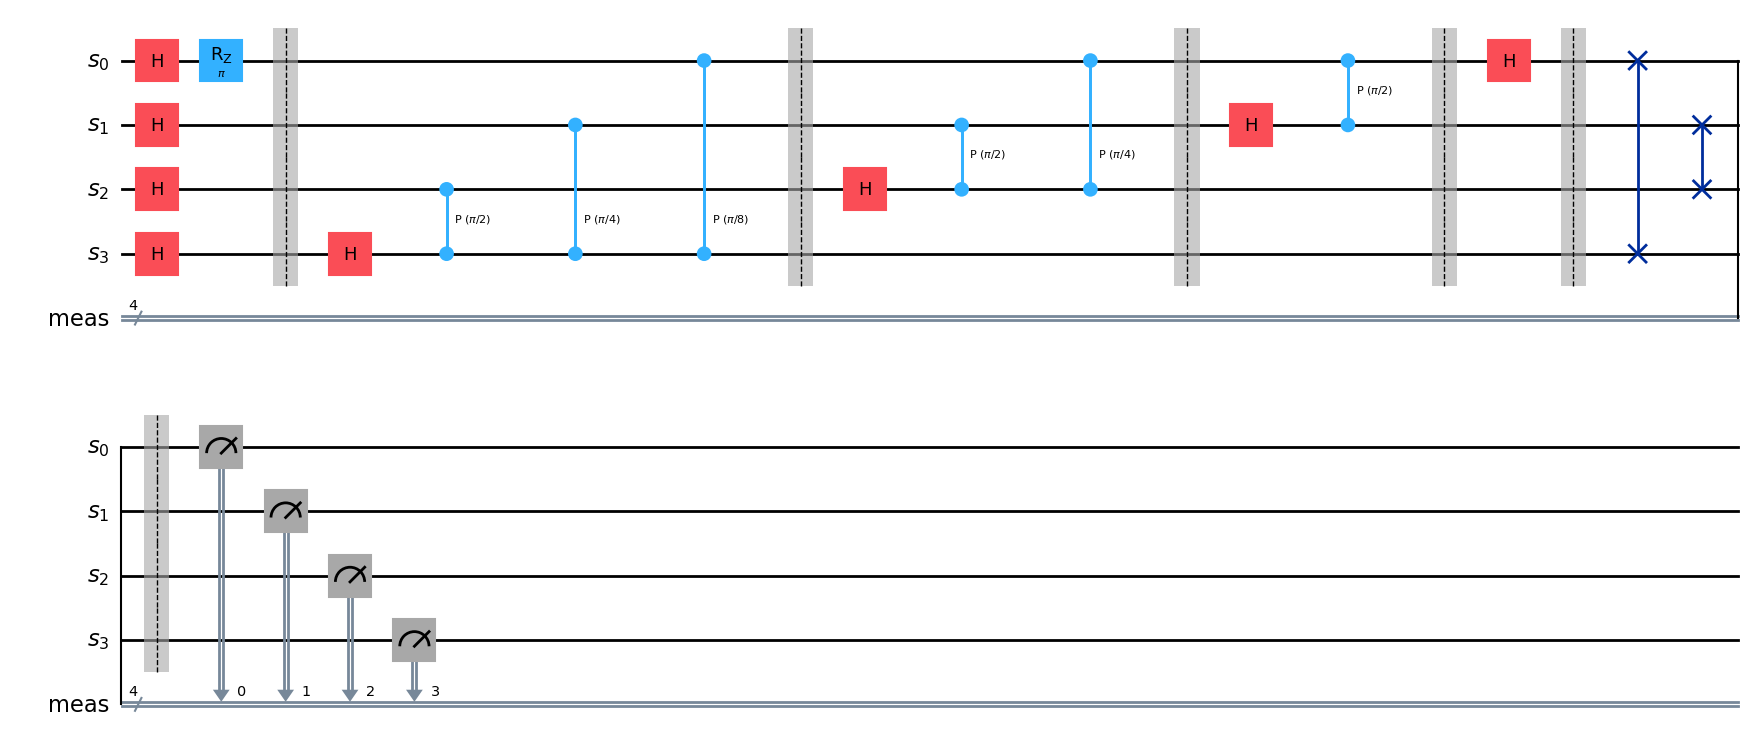

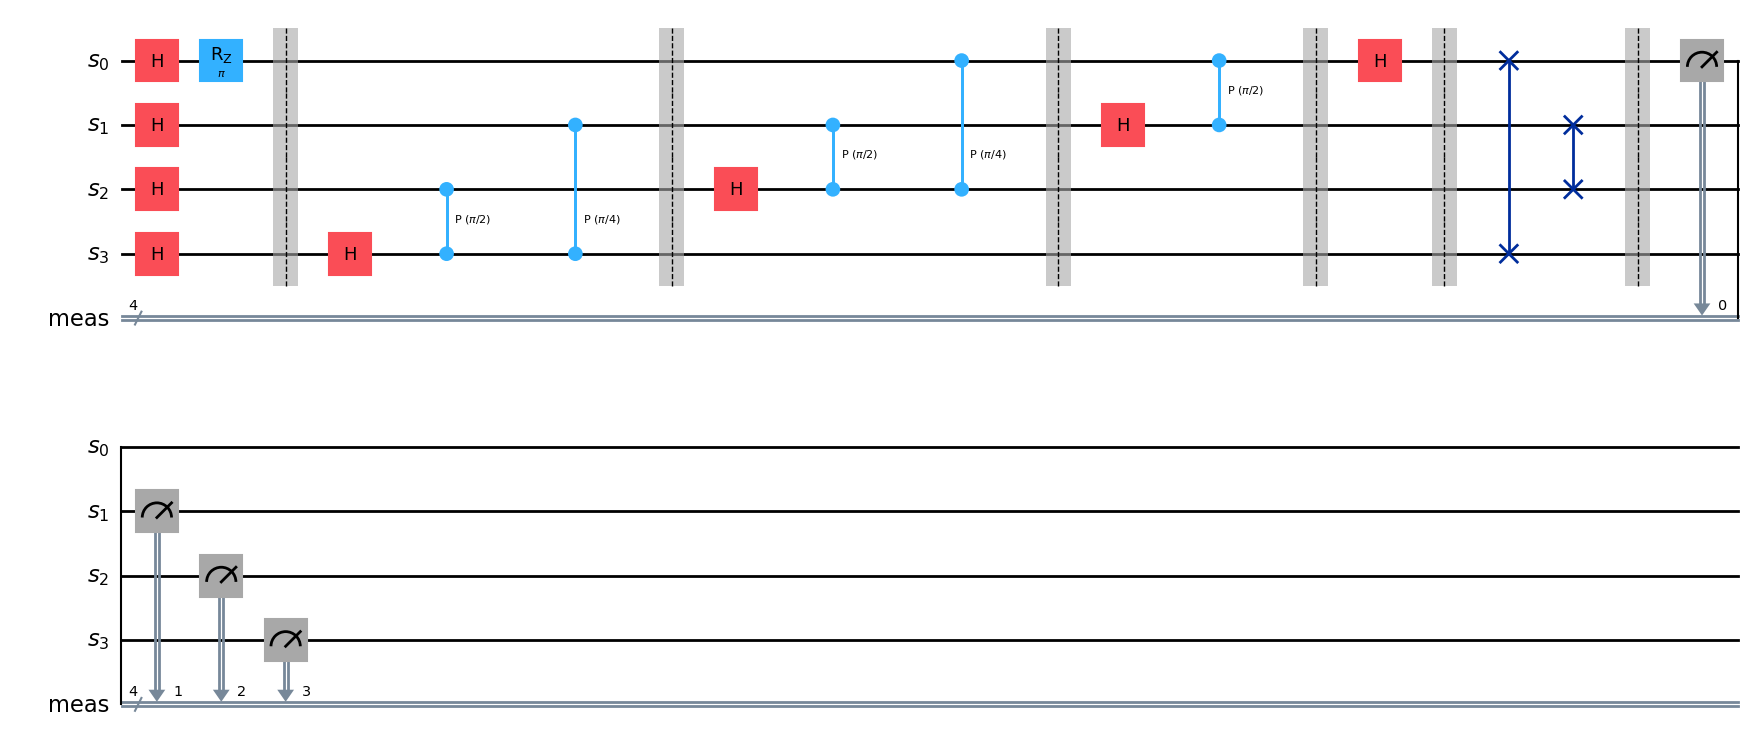

In [7]:
sa1 = crear_señal('A') #A este le voy a aplicar la QFT 
sa2 = crear_señal('A') #A este le voy a aplicar la AQFT con 2 rotaciones máximas

sa1 = qft_n_qubits(sa1, 4)
sa1.measure_all()
display(sa1.draw('mpl'))

sa2 = aqft_NM(sa2, 4, 2)
sa2.measure_all()
display(sa2.draw('mpl'))

Simulo el circuito QFT con la señal A

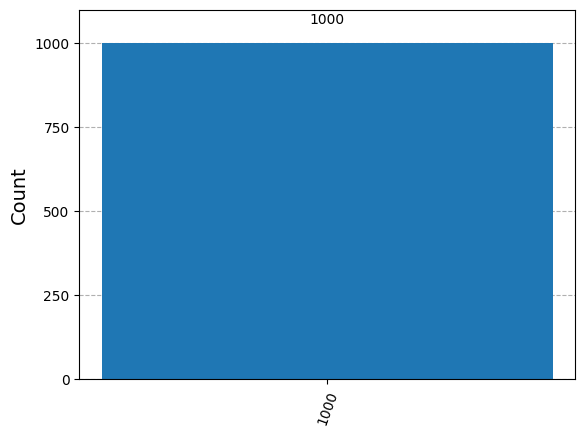

In [8]:
backend = Aer.get_backend('qasm_simulator')
tsa1 = transpile(sa1, backend = backend, optimization_level= 1)
job = backend.run(tsa1, shots = 1000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

Simulo el circuito AQFT con la señal A

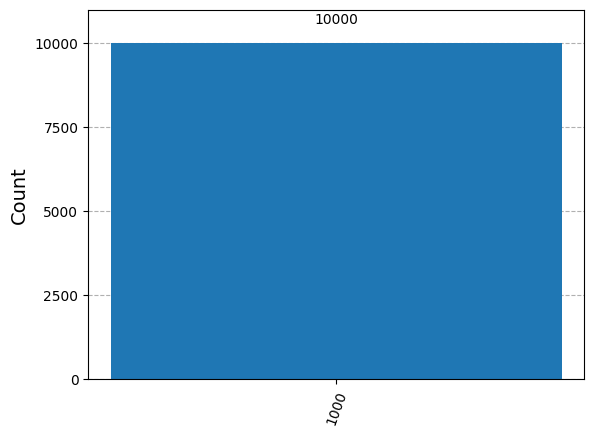

In [9]:
backend = Aer.get_backend('qasm_simulator')
tsa2 = transpile(sa2, backend = backend, optimization_level= 1)
job = backend.run(tsa2, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

Lo pruebo con state_vector y funciona igual

In [10]:
backend = Aer.get_backend('statevector_simulator')
tsa2 = transpile(sa2, backend = backend, optimization_level= 1)
job = backend.run(tsa2)
result = job.result()

outputstate = result.get_statevector(tsa2, decimals=3)
display(array_to_latex(outputstate))

for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

<IPython.core.display.Latex object>

|8> (-0-1j) probabilidad = 100.0%


Pruebo con la señal B

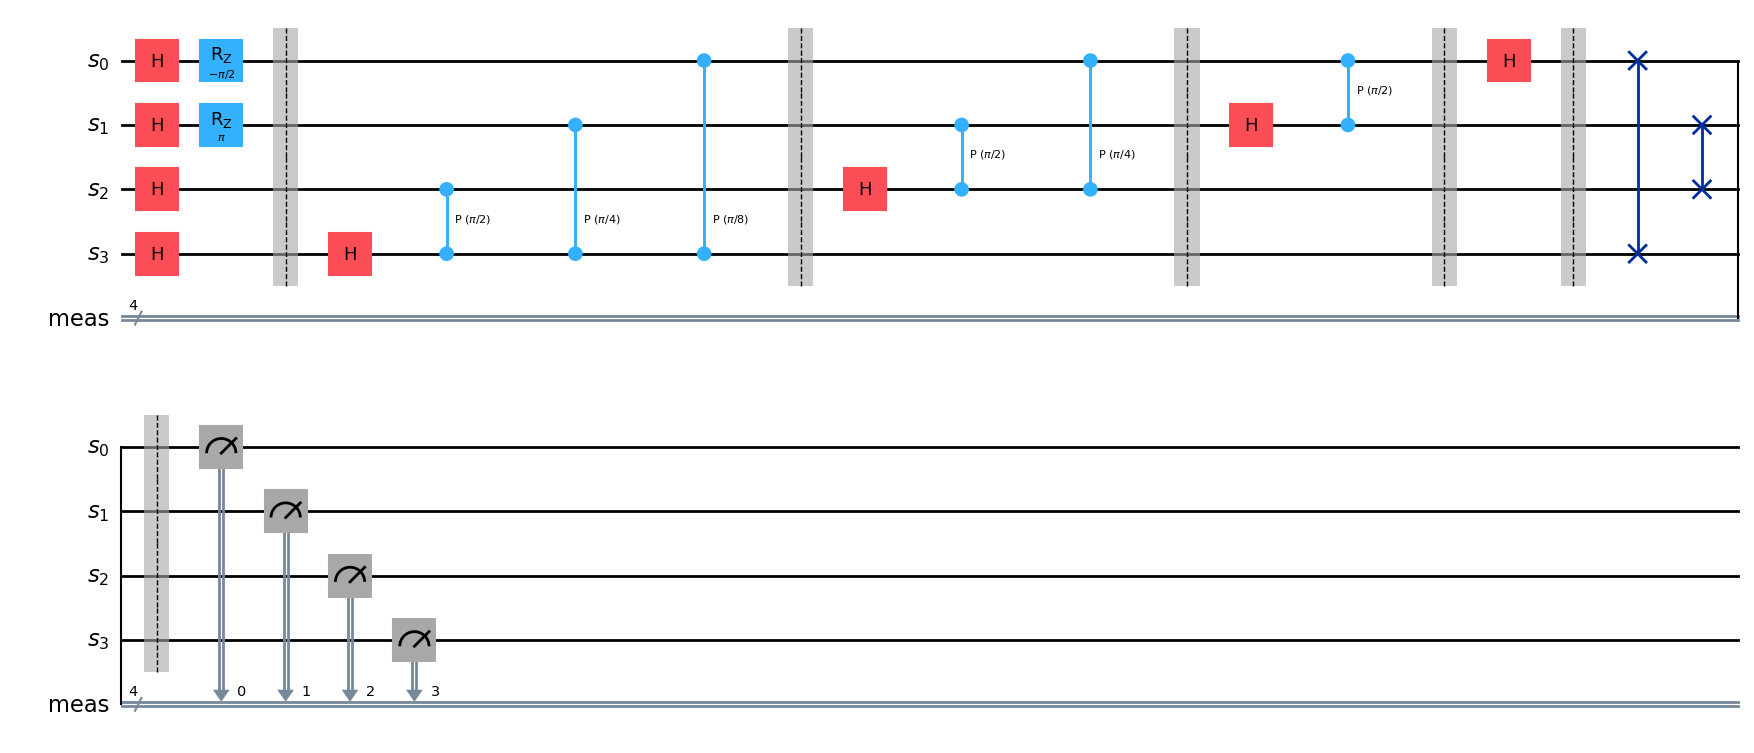

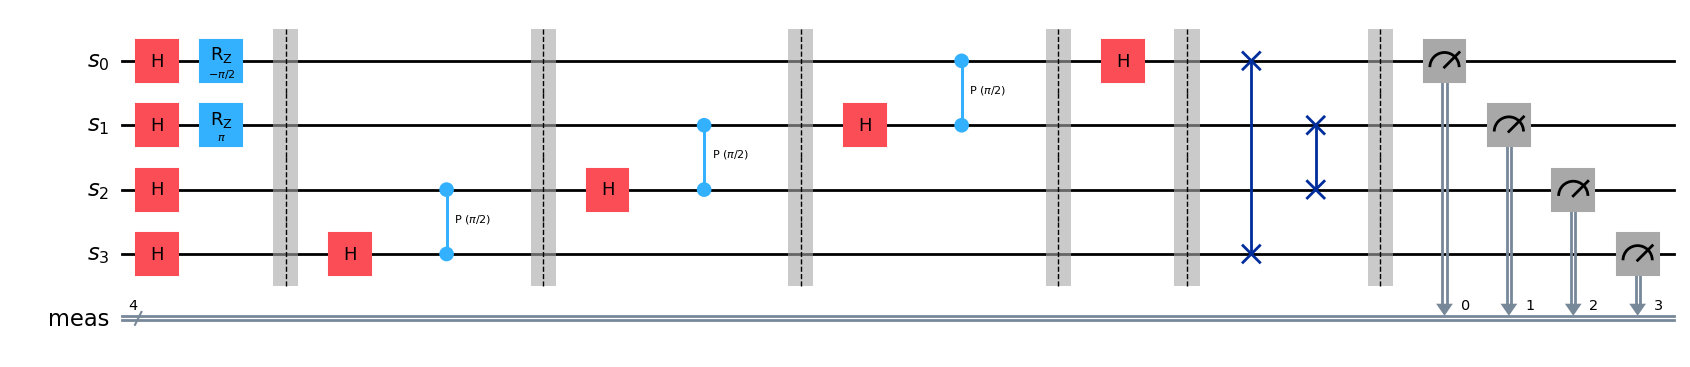

In [11]:
sb1 = crear_señal('B') #A este le voy a aplicar la QFT 
sb2 = crear_señal('B') #A este le voy a aplicar la AQFT con 2 rotaciones máximas

sb1 = qft_n_qubits(sb1, 4)
sb1.measure_all()
display(sb1.draw('mpl'))

sb2 = aqft_NM(sb2, 4, 1)
sb2.measure_all()
display(sb2.draw('mpl'))

In [12]:
backend = Aer.get_backend('statevector_simulator')
tsb2 = transpile(sb2, backend = backend, optimization_level= 1)
job = backend.run(tsb2)
result = job.result()

outputstate = result.get_statevector(tsb2, decimals=3)
display(array_to_latex(outputstate))

for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

<IPython.core.display.Latex object>

|4> (0.707-0.707j) probabilidad = 99.9698%


Pruebo con la señal C

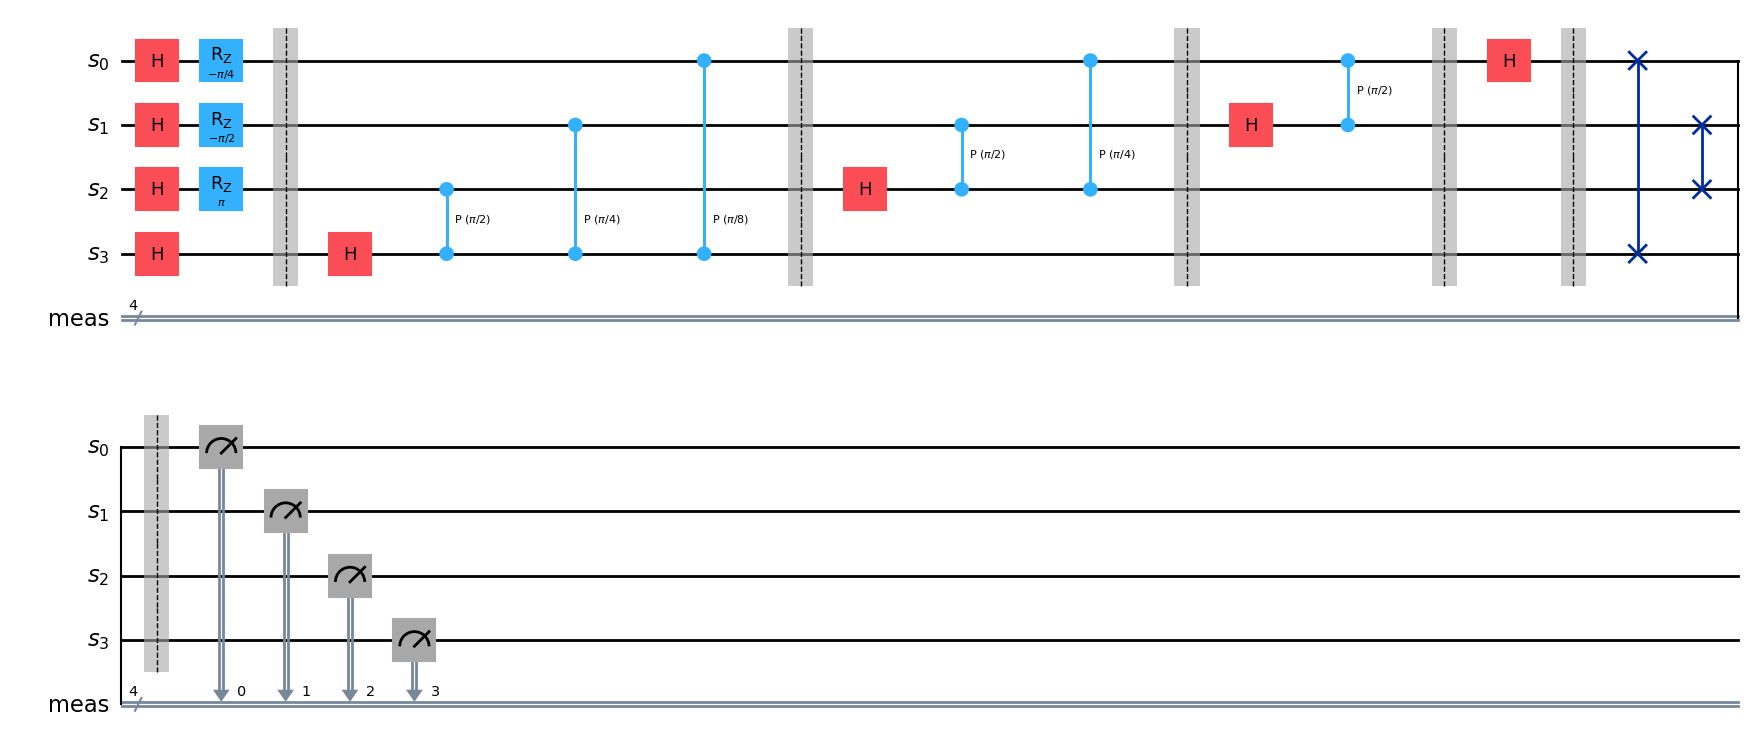

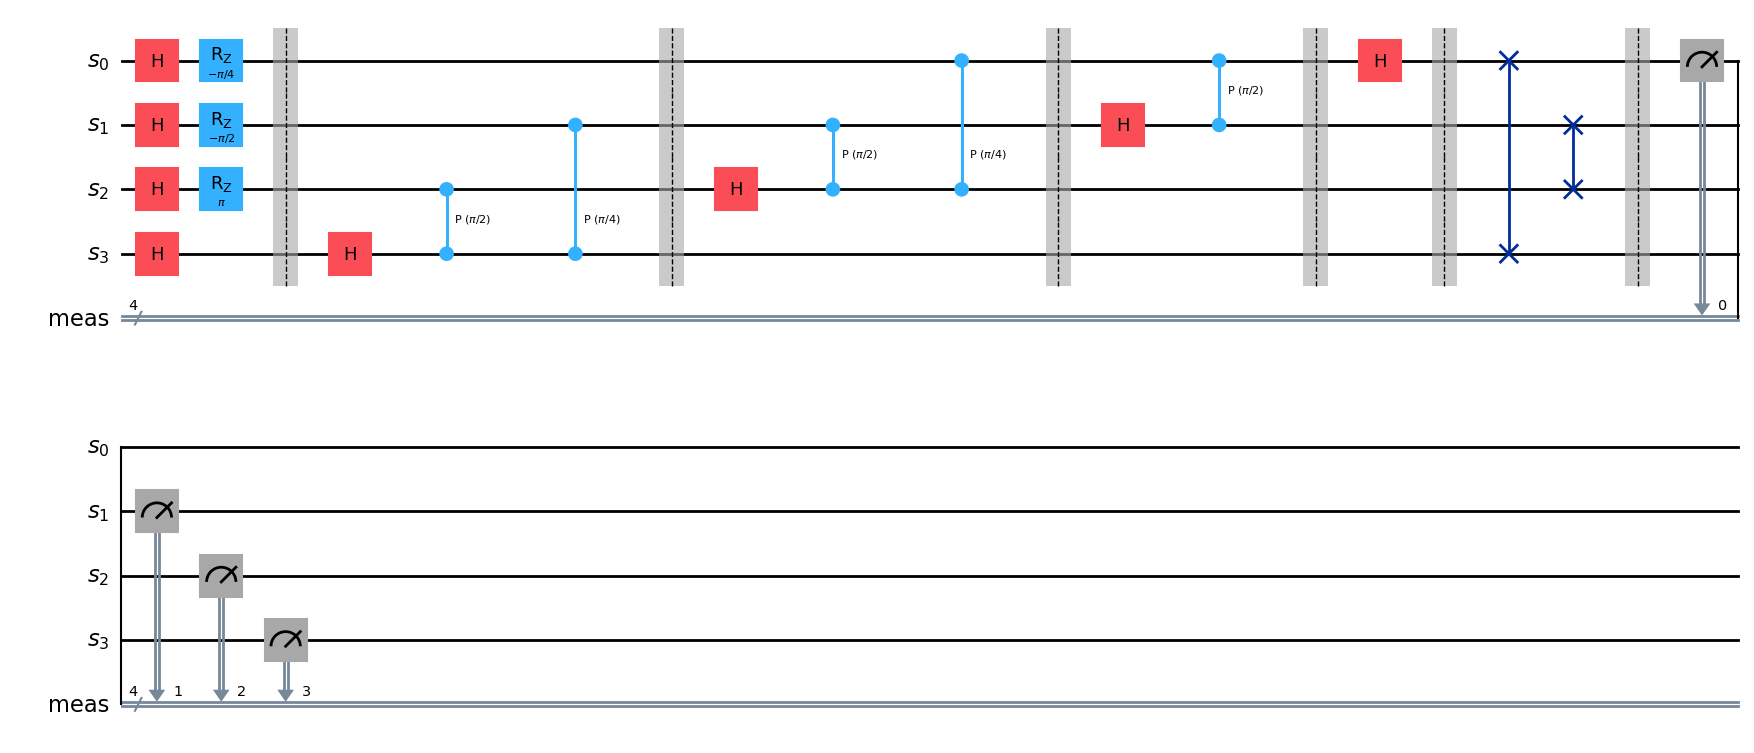

In [13]:
sc1 = crear_señal('C') #A este le voy a aplicar la QFT 
sc2 = crear_señal('C') #A este le voy a aplicar la AQFT con 2 rotaciones máximas

sc1 = qft_n_qubits(sc1, 4)
sc1.measure_all()
display(sc1.draw('mpl'))

sc2 = aqft_NM(sc2, 4, 2)
sc2.measure_all()
display(sc2.draw('mpl'))

In [14]:
backend = Aer.get_backend('statevector_simulator')
tsc2 = transpile(sc2, backend = backend, optimization_level= 1)
job = backend.run(tsc2)
result = job.result()

outputstate = result.get_statevector(tsc2, decimals=5)
display(array_to_latex(outputstate))

for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

<IPython.core.display.Latex object>

|2> (0.92388-0.38268j) probabilidad = 99.99982%


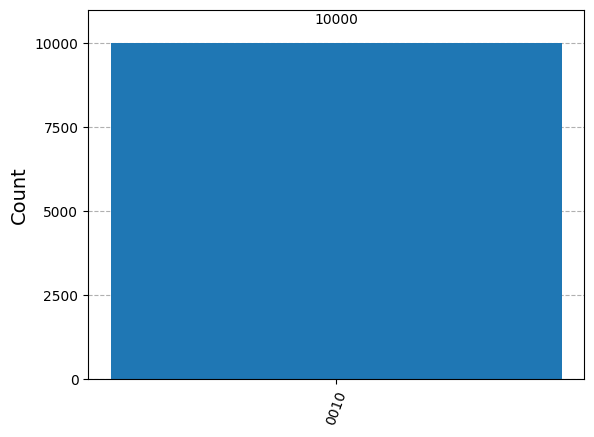

In [15]:
backend = Aer.get_backend('qasm_simulator')
tsc2 = transpile(sc2, backend = backend, optimization_level= 1)
job = backend.run(tsc2, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

Tras probar los tres tipos de señales, se puede observar que AQFT para 4 qubits con 2 rotaciones como máximo funciona exactamente igual que la QFT normal de 4 qubits.\
Al fin y al cabo se ha eliminado únicamente una rotacion de $\frac{\pi}{8}$.\
Se observa que el statevector tras la ejecucion del circuito se queda igual.

No obstante si probamos a ejecutar la AQFT con 1 rotación como máximo, ahí el resultado ya es diferente.

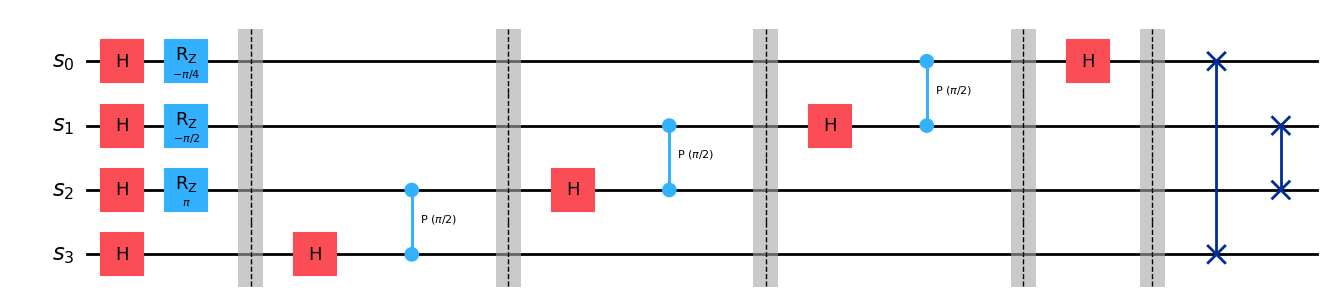

<IPython.core.display.Latex object>

|2> (0.65328-0.65328j) probabilidad = 85.35495%
|10> (0.2706+0.2706j) probabilidad = 14.64487%


In [16]:
sc3 = crear_señal('C')
aqft_NM(sc3, 4, 1)
display(sc3.draw('mpl'))


backend = Aer.get_backend('statevector_simulator')
tsc3 = transpile(sc3, backend = backend, optimization_level= 1)
job = backend.run(tsc3)
result = job.result()

outputstate = result.get_statevector(tsc3, decimals=5)
display(array_to_latex(outputstate))

for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probabilidad = {}%'.format(i, amp, round(prob * 100, 5)))

Aún así el estado mayoritario sigue siendo el correcto

##### Explicación del ejercicio

En este ejercicio se nos pedia implementar una QFT de 4 qubits y una AQFT de 4 qubits con un máximo de 2 rotaciones de fase por qubit.
Esta AQFT no se cambia mucho con respecto a la QFT porque solo se le elimina una rotación de fase de $\frac{\pi}{2^3}$ al qubit más significativo.\
Sea nuestro estado: $$\ket{x} = \ket{q_{3}q_{2}q_{1}q_{0}}$$

Si le aplicamos la QFT: $$QFT(\ket{x}) = \frac{1}{\sqrt{2^4}}(\ket{0} + e^{2 \pi i \frac{x}{2}}\ket{1}) \otimes
                                                    (\ket{0} + e^{2 \pi i \frac{x}{2^2}}\ket{1}) \otimes
                                                    (\ket{0} + e^{2 \pi i \frac{x}{2^3}}\ket{1}) \otimes
                                                    (\ket{0} + e^{2 \pi i \frac{x}{2^4}}\ket{1})$$

Si le aplicamos la AQFT: $$QFT(\ket{x}) = \frac{1}{\sqrt{2^4}}(\ket{0} + e^{2 \pi i \frac{x}{2}}\ket{1}) \otimes
                                                    (\ket{0} + e^{2 \pi i \frac{x}{2^2}}\ket{1}) \otimes
                                                    (\ket{0} + e^{2 \pi i \frac{x}{2^3}}\ket{1}) \otimes
                                                    (\ket{0} + e^{2 \pi i \frac{x}{2^3}}\ket{1})$$
Vemos que al qubit menos significativo (después de haber aplicado las SWAPS) de la QFT se le ha aplicado una Rotacion de fase de $2 \pi  \frac{x}{2^4} radianes $ y a la AQFT se le aplica una rotacion de fase de $2 \pi  \frac{x}{2^3} radianes $. 
La demostración se encuentra en las siguientes imagenes:
- La descomposicion de la QFT para 4 qubits:\
<img src="QFT_4Qubits_1.jpg" width="500"> <img src="QFT_4Qubits_2.jpg" width="500"> \

- La descomposicion de la AQFT para 4 qubits y 2 rotaciones máximas:\
<img src="AQFT_4Qubits_2Rot.jpg" width="400">





Ahora la pregunta que nos podemos hacer es la siguiente:\
¿Por qué obtenemos el mismo resultado con la QFT y la AQFT para los 3 tipos de señales que hemos creado en la parte A de la práctica?

La respuesta es que los 3 tipos de señales solo aplican RZ, es decir, rotaciones sobre el eje Z, a los qubits 0, 1 y 2 como mucho, pero en el qubit 3 no se aplica nada. La AQFT solo tiene le falta una rotación de fase en el qubit 3 de $\frac{\pi}{2^3}$, pero eso no afecta al resultado de las operaciones por las que pasan los qubits a los que se les ha aplicado las $RZs$.\
En estas 3 señales es como si simplemente aplicásemos una QFT sobre $\ket{q_{2}q_{1}q_{0}}$ y nos olvidamos de $q_3$. Pero, todo esto es antes de los SWAPs. Después de pasar por todos los operadores ya los SWAPs colocan bien los valores.

Para empezar la $RZ$ de Qiskit implementa la siguiente matriz unitaria:
$$RZ(\phi) = \begin{pmatrix}
                e^{-i \frac{\phi}{2}} & 0 \\
                0 & e^{i \frac{\phi}{2}}
                \end{pmatrix}$$

Entonces: $$RZ(\phi)(\ket{0}) = e^{-i \frac{\phi}{2}}\ket{0}$$ $$RZ(\phi)(\ket{1}) = e^{i \frac{\phi}{2}}\ket{1}$$

- Para el caso de la señal A tenemos:
$$(H\ket{0})\otimes (H\ket{0}) \otimes (H\ket{0}) \otimes (RZ(\pi)H\ket{0})$$

Esto es igual a: $$\frac{1}{\sqrt{2^4}}(\ket{0} + \ket{1}) \otimes
                                                    (\ket{0} + \ket{1}) \otimes
                                                    (\ket{0} + \ket{1}) \otimes
                                                    (e^{-i \frac{\pi}{2}}\ket{0} + e^{i \frac{\pi}{2}}\ket{1})$$

Teniendo la señal A, si lo hacemos pasar por la QFT o AQFT, al pasar por la primera $Hadamard$ que es la de $q_3$ pasamos al siguiente estado:
$$\frac{1}{\sqrt{2^3}}\ket{0} \otimes
                        (\ket{0} + \ket{1}) \otimes
                        (\ket{0} + \ket{1}) \otimes
                        (e^{-i \frac{\pi}{2}}\ket{0} + e^{i \frac{\pi}{2}}\ket{1})$$
No importa las rotaciones $CR_{\psi}$ que se apliquen a continuacion sobre $q_3$, simplemente no se hará nada a $\ket{0}$ ya sea en la QFT o en la AQFT que le falta una rotación, pero no importaría, pues aquí no afecta. 
Después de pasar por la $H$ y rotaciones de $q_2$ y $q_1$ obtenemos el siguiente estado:
$$\frac{1}{\sqrt{2}}\ket{000} \otimes
                        (e^{-i \frac{\pi}{2}}\ket{0} + e^{i \frac{\pi}{2}}\ket{1})$$

Si aplicamos la ultima $Hadamard$ que es la de $q_0$:
$$\frac{1}{2}\ket{000} \otimes
                    (e^{-i \frac{\pi}{2}}(\ket{0} + \ket{1}) + e^{i \frac{\pi}{2}}(\ket{0} - \ket{1})) = 
\frac{1}{2}\ket{000} \otimes
                    ((e^{-i \frac{\pi}{2}} + e^{i \frac{\pi}{2}})\ket{0} + (e^{-i \frac{\pi}{2}} - e^{i \frac{\pi}{2}})(\ket{1}))$$
Sabemos que: $$(e^{-i \frac{\pi}{2}} + e^{i \frac{\pi}{2}}) = (-i + i) = 0$$ $$(e^{-i \frac{\pi}{2}} - e^{i \frac{\pi}{2}}) = (-i - i) = -2i$$.

Entonces consequimos con la QFT y la AQFT antes de los SWAPs:
    $$-i\ket{0001}$$.
Tras los SWAPs: $$-i\ket{1000}$$.


- El procedimiento para la señal B es la misma que con A.

Voy a pasar a realizar la señal C que es mas interesante.

- Para el caso de C: 
$$(H\ket{0})\otimes (RZ(\pi)(H\ket{0}) \otimes (RZ(-\frac{\pi}{2}))(H\ket{0}) \otimes (RZ(-\frac{\pi}{4}))H\ket{0})$$

Esto es igual a: $$\frac{1}{\sqrt{2^4}}(\ket{0} + \ket{1}) \otimes
                                    (e^{-i \frac{\pi}{2}}\ket{0} + e^{i \frac{\pi}{2}}\ket{1}) \otimes
                                    (e^{i \frac{\pi}{4}}\ket{0} + e^{-i \frac{\pi}{4}}\ket{1}) \otimes
                                    (e^{i \frac{\pi}{8}}\ket{0} + e^{-i \frac{\pi}{8}}\ket{1})$$


Tras aplicar la primera $Hadamard$ en la QFT y la AQFT, el qubit $q_3$ ya pasa a $\ket{0}$, por lo que las rotaciones de a continuacion no le afectan.
$$\frac{1}{\sqrt{2^3}}\ket{0} \otimes
                            (e^{-i \frac{\pi}{2}}\ket{0} + e^{i \frac{\pi}{2}}\ket{1}) \otimes
                            (e^{i \frac{\pi}{4}}\ket{0} + e^{-i \frac{\pi}{4}}\ket{1}) \otimes
                            (e^{i \frac{\pi}{8}}\ket{0} + e^{-i \frac{\pi}{8}}\ket{1})$$
Tras aplicar la $H$ a $q_2$ y las rotaciones correspondientes.
$$\frac{-i}{\sqrt{2^2}}\ket{01} \otimes
                            (e^{i \frac{\pi}{4}}\ket{0} + e^{-i \frac{\pi}{4}}\ket{1}) \otimes
                            (e^{i \frac{\pi}{8}}\ket{0} + e^{-i \frac{\pi}{8}}\ket{1})$$

Tras aplicar la $H$ a $q_1$ y la rotacion controlada.
$$\frac{e^{\frac{7\pi i}{4}}}{\sqrt{2}}\ket{010} \otimes
                    (e^{i \frac{\pi}{8}}\ket{0} + e^{-i \frac{\pi}{8}}\ket{1})$$

Tras aplicar la última $H$ a $q_0$ obtenemos:
$$e^{\frac{15\pi i}{8}}\ket{0100}$$

Los SWAPs finales:
$$e^{\frac{15\pi i}{8}}\ket{0010}$$

Cálculos intermedios:\
<img src="Senyal_C_1.jpg" width="500"> <img src="Senyal_C_2.jpg" width="500"> 

### Conclusión

Las señales que hemos usado al ser solo rotaciones de Z sobre los 3 qubits menos significativos, el resultado de la QFT y la AQFT van a ser los mismos ya que solo se diferencian por una rotación de fase faltante en la AQFT en el 4º qubit, el más significativo.\
Eso no significa que siempre den el mismo resultado, pues son diferentes en esencia, aunque esa diferencia no es mucha.\
Solamente ha dado la casualidad que estas 3 señales hace que se obtengan el mismo resultado pues en esencia solo les estamos aplicando una QFT y AQFT de 3 qubits en vez de 4.

No obstante, si creamos una señal donde se incluya también a $q_3$, el más significativo, el state_vector que obtendremos ya dejaría de ser exactamente el mismo. Pese a no ser el mismo son "muy parecidos".
Por ejemplo si la QFT devuelve $\ket{0001}$, la AQFT devolverá algo así: $\beta\ket{0001} + \alpha\ket{1001}$ siendo $\beta >>> \alpha$, es decir, la amplitud $\beta$ será mucho mayor que $\alpha$.

## Ejercicio 2

Para empezar voy a declarar las dos funciones para crear la inversa de la QFT y de la AQFT.


In [17]:
def inverse_qft(circuit, n, swaps = True, barrier = True):
    """Funcion que implementa la QFT inversa para los n primeros bits de un circuito cuantico"""
    # Creamos el circuito de n bits
    qft_circ = qft_n_qubits(QuantumCircuit(n), n, swaps, barrier)
    # Calculamos el circuito inverso
    invqft_circ = qft_circ.inverse()
    # lo añadimos al circuito creado
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit

In [18]:
def inverse_aqft(circuit, n, m, swaps = True, barrier = True):
    """Funcion que implementa la AQFT inversa para n qubits y un maximo de m rotaciones"""
    # Creamos el circuito de n bits
    aqft_circ = aqft_NM(QuantumCircuit(n), n, m, swaps, barrier)
    # Calculamos el circuito inverso
    invaqft_circ = aqft_circ.inverse()
    # lo añadimos al circuito creado
    circuit.append(invaqft_circ, circuit.qubits[:n])
    return circuit

#### Sumador de Draper con QFT de 4 qubits

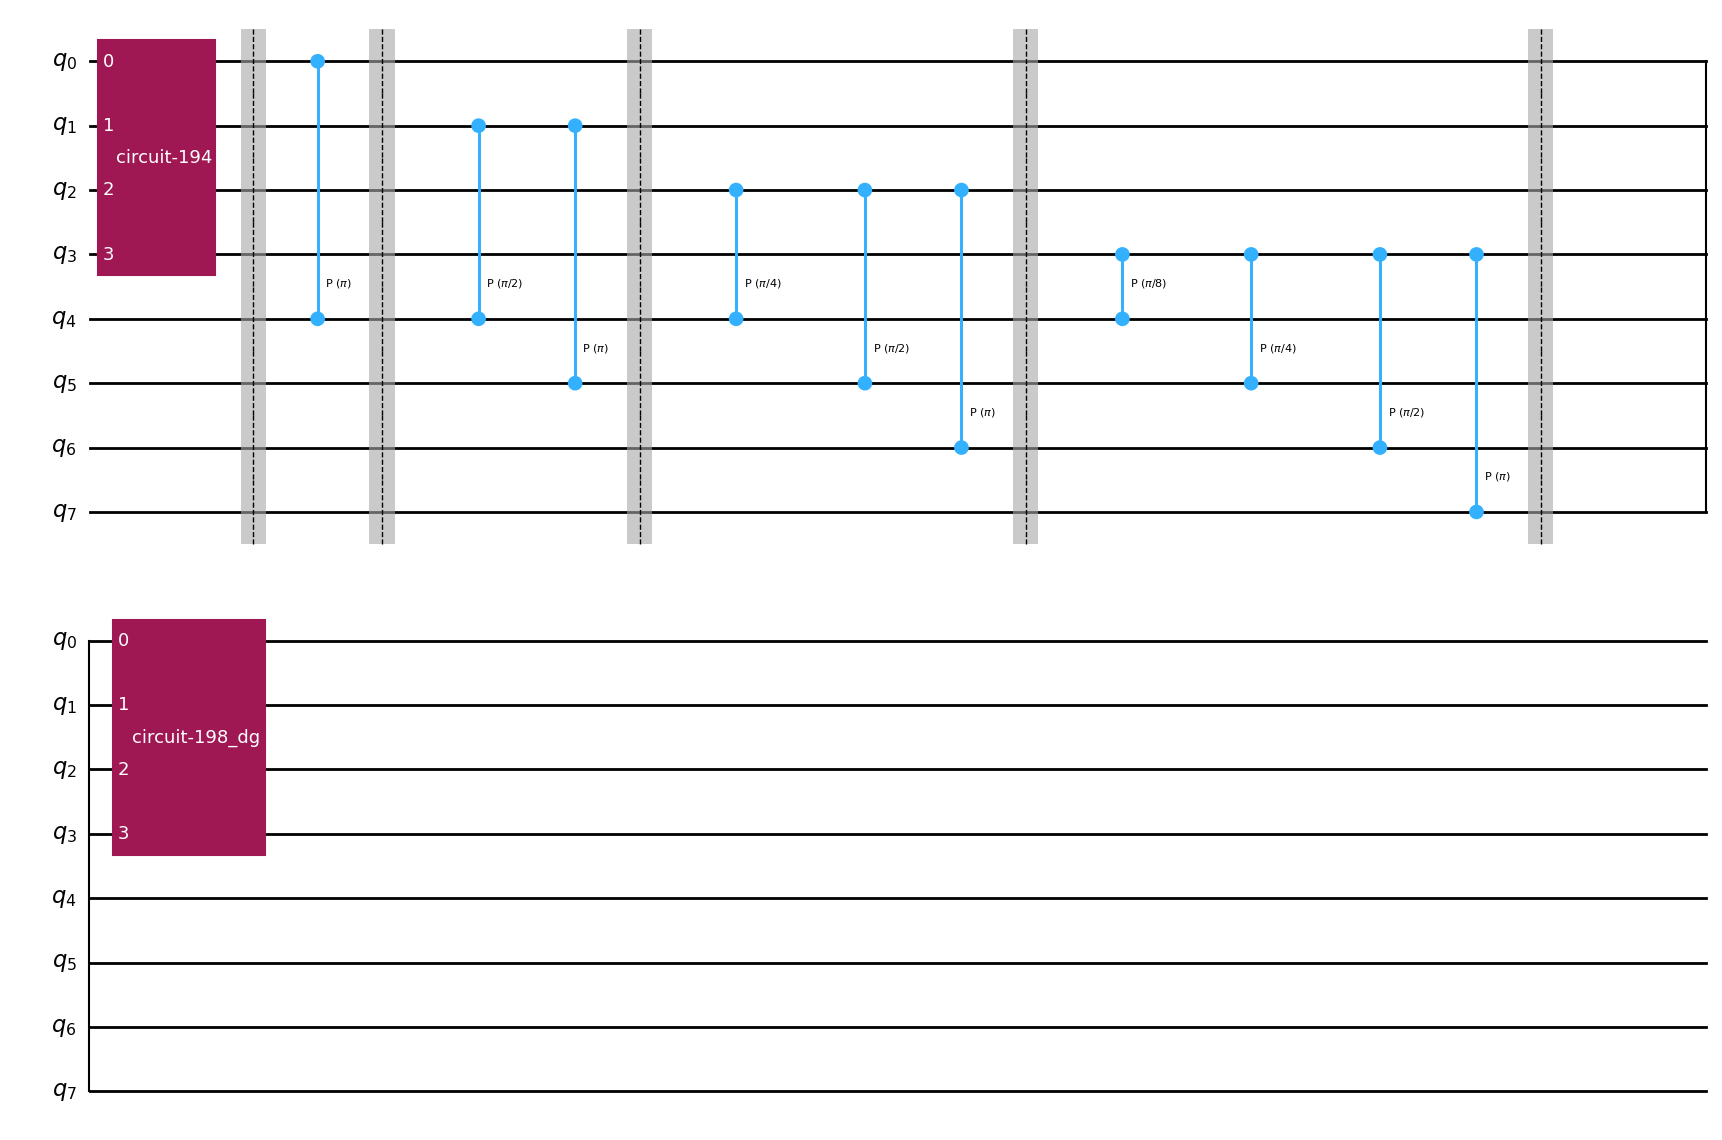

In [21]:
n = 8
#qft = qft_n_qubits(QuantumCircuit(n//2), n//2, swaps = False, barrier = False)
qft = qft_n_qubits(QuantumCircuit(n//2), n//2, swaps = False)

#iqft = inverse_qft(QuantumCircuit(4), 4)

drqft = QuantumCircuit(n, name = 'Sum_draper')

#Implemento la QFT a los primeros 4 qubits
drqft.append(qft, [i for i in range(n//2)])
drqft.barrier()
for i in range(n//2): #Por a cada Ai
    for j in range(i + 1): #Por cada Bj que empieza en 4
        drqft.cp(math.pi/2**(i - j), drqft.qubits[j + n//2], drqft.qubits[i]) #El control es Bj (qubit j + 4) y el objetivo es Ai (qubit i)
    drqft.barrier()


#Le aplico la QFT inversa
#inverse_qft(drqft, n//2, swaps = False, barrier = False)
inverse_qft(drqft, n//2, swaps = False)

display(drqft.draw('mpl'))

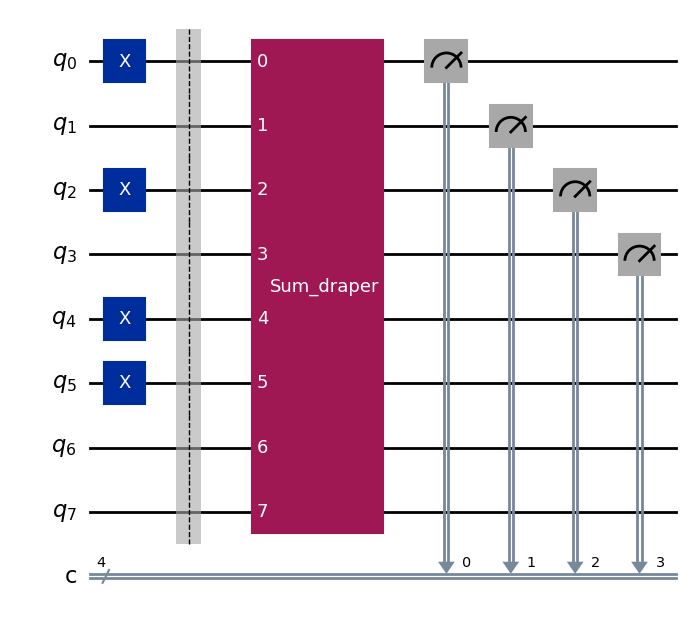

In [22]:
sum1 = QuantumCircuit(n, n//2)


sum1.x(n//2)
sum1.x(n//2 + 1)
sum1.x(0)
sum1.x(2)

sum1.barrier()

sum1.append(drqft, sum1.qubits)

#sum1.measure_all()

sum1.measure([i for i in range(n//2)], [i for i in range(n//2)])


display(sum1.draw('mpl'))


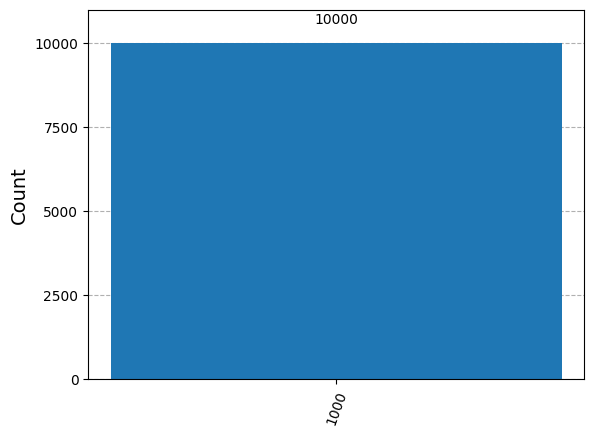

In [23]:
backend = Aer.get_backend('qasm_simulator')
tsum1 = transpile(sum1, backend = backend, optimization_level= 1)

job = backend.run(tsum1, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

In [24]:
backend = Aer.get_backend('statevector_simulator')
tsum1 = transpile(sum1, backend = backend, optimization_level= 1)  #opcional

job = backend.run(tsum1)
result = job.result()

outputstate = result.get_statevector(tsum1, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))

|56> (1-0j) probability = 100.0%


En esta prueba estoy sumando los valores siguientes:\
$\ket{b} = \ket{0011} = \ket{3}$\
$\ket{a} = \ket{0101} = \ket{5}$\
Entonces: $\ket{b}\ket{a + b} = \ket{3}\ket{8} = \ket{0011}\ket{1000} = \ket{56}$ que es lo que sale en el state vector. 

Para la implementacion del sumador he usado la QFT que hemos dado en clase, pero sin añadir los SWAPs finales para cambiar los qubits más significativos por los menos. La razón es porque el procedimiento que enseña Draper en su paper para implementar el sumador está pensado para una QFT sin aplicar SWAPs.

Si realizamos $QFT_{Swaps = false}\ket{a}$ obtenemos: 
    $$QFT_{Swaps = false}\ket{a} = \ket{\phi_{n-1}(a)}\otimes\ket{\phi_{n}(a)}\otimes...\otimes \ket{\phi_{1}(a)}\otimes \ket{\phi_{0}(a)}$$

Si realizamos $QFT_{Swaps = true}\ket{a}$ obtenemos: 
    $$QFT_{Swaps = true}\ket{a} = \ket{\phi_{0}(a)}\otimes\ket{\phi_{1}(a)}\otimes...\otimes \ket{\phi_{n - 2}(a)}\otimes \ket{\phi_{n - 1}(a)}$$

Siendo $$\ket{\phi_{k}(a)} = \frac{1}{\sqrt{2}}(\ket{0} + e^{\frac{2\pi i a}{2^{k + 1}}}\ket{1})$$

Que se obtiene previamente a los SWAPs mediante una $Hadamard$ e $i - 1$ rotaciones de fase controladas por los $i - 1$ qubits menos significativos. 

Entonces la propuesta de Draper para obtener la suma de $a + b$ en los qubits de $a$ es realizar las mismas rotaciones a cada qubit que en la QFT, pero ahora controlados por los $i$ qubits menos signficativos de $b$, pero para una QFT sin SWAPs.\
Es decir, quiere conseguir:
$$\ket{\phi_{k}(a + b)} = \frac{1}{\sqrt{2}}(\ket{0} + e^{\frac{2\pi i a}{2^{k + 1}}}e^{\frac{2\pi i b}{2^{k + 1}}}\ket{1})$$

Así cuando aplicamos la $QFT^{\dagger}$ en los qubits de $a$ obtenemos $a + b$. 


No obstante, si realizamos estas mismas rotaciones a una $a$ al que se le ha aplicado una $QFT$ con SWAPs, pasariamos a tener los siguiente para el qubit $i$:
$$\frac{1}{\sqrt{2}}(\ket{0} + e^{\frac{2\pi i a}{2^{k + 1}}}e^{\frac{2\pi i b}{2^{n - k}}}\ket{1})$$

Por tanto, al aplicar la inversa no obtendríamos lo que queremos. 

(*): En el anexo o extra implementaré la forma correcta de Draper para QFT con SWAPs

#### Sumador de Draper con AQFT de 4 qubits y un másximo de 2 rotaciones

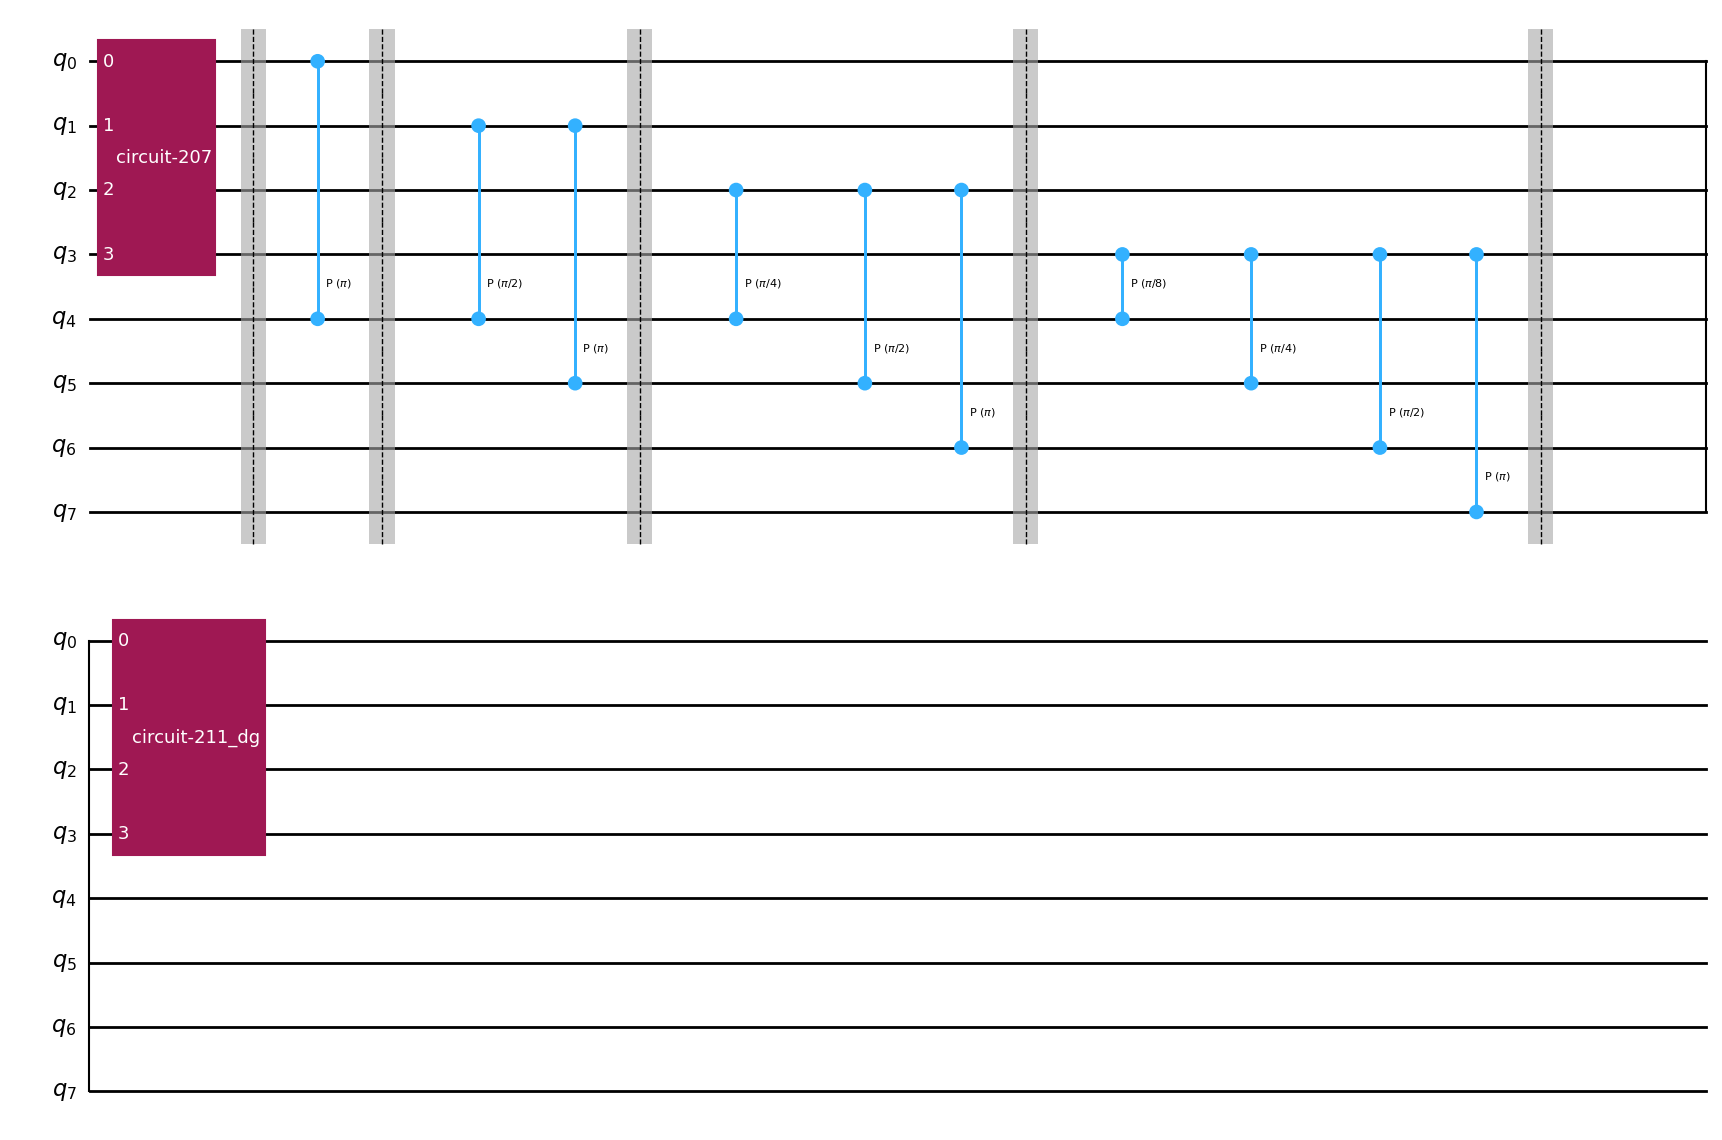

In [25]:
n = 8
#aqft = aqft_NM(QuantumCircuit(n//2), n//2, 2, swaps = False, barrier = False)
aqft = aqft_NM(QuantumCircuit(n//2), n//2, 2, swaps = False)
#iqft = inverse_qft(QuantumCircuit(4), 4)

draqft = QuantumCircuit(n, name = 'Sum_draper_AQFT')

#Implemento la AQFT a los primeros 4 qubits
draqft.append(aqft, [i for i in range(n//2)])
draqft.barrier()
for i in range(n//2): #Por a cada Ai
    for j in range(i + 1): #Por cada Bj que empieza en 4
        draqft.cp(math.pi/2**(i - j), draqft.qubits[j + n//2], draqft.qubits[i]) #El control es Bj (qubit j + 4) y el objetivo es Ai (qubit i)
    draqft.barrier()


#Le aplico la QFT inversa
#inverse_aqft(draqft, n//2, 2, swaps = False, barrier = False)
inverse_aqft(draqft, n//2, 2, swaps = False)

display(draqft.draw('mpl'))

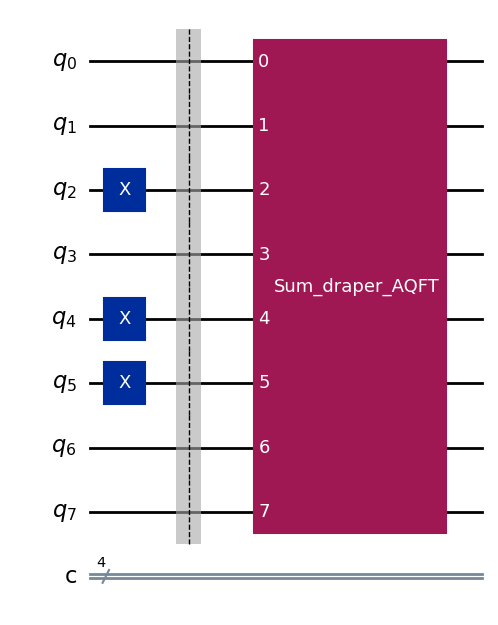

In [33]:
sum2 = QuantumCircuit(n, n//2)


sum2.x(n//2)
sum2.x(n//2 + 1)
#sum2.x(0)
sum2.x(2)

sum2.barrier()

sum2.append(draqft, sum2.qubits)

#sum2.measure_all()

#sum2.measure([i for i in range(n//2)], [i for i in range(n//2)])


display(sum2.draw('mpl'))

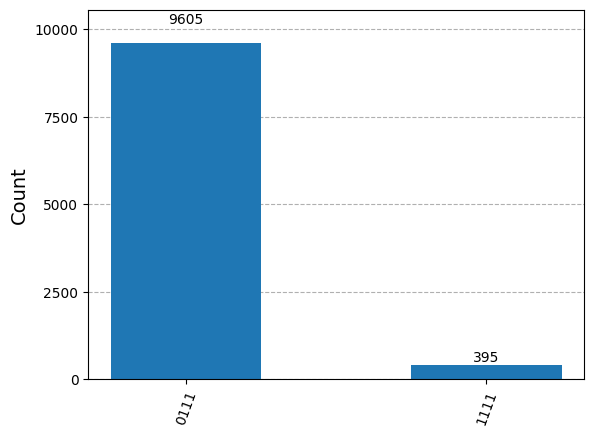

In [27]:
backend = Aer.get_backend('qasm_simulator')
tsum2 = transpile(sum2, backend = backend, optimization_level= 1)

job = backend.run(tsum2, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

In [31]:
backend = Aer.get_backend('statevector_simulator')
tsum2 = transpile(sum2, backend = backend, optimization_level= 1)  #opcional

job = backend.run(tsum2)
result = job.result()

outputstate = result.get_statevector(tsum2, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))

|55> (0.962+0.191j) probability = 96.1925%
|63> (0.038-0.191j) probability = 3.7925%


En este caso no obtenemos un valor tan exacto.\
Estos sumado $\ket{a} = \ket{0100} = \ket{4}$ mas $\ket{b} = \ket{0011} = \ket{3}$\
Sumando $a + b$ la mayoria de las veces obtenemos $7 = 0111$ pero hay una pequeña amplitud en el valor $15 = 1111$ que nos hace obtenerlo en algunas mediciones aunque con una probabilidad muy pequeña.\
Sea $\ket{c} = \ket{a + b}$

$$AQFT_{swaps = false}\ket{a} = \ket{\phi_{2}(a)}\otimes\ket{\phi_{2}(a)}\otimes\ket{\phi_{1}(a)}\otimes \ket{\phi_{0}(a)}$$

Vemos que para el qubit más significativo tenemos $\ket{\phi_{2}(a)}$ en vez de $\ket{\phi_{3}(a)}$ de la QFT. 

Tras aplicar las rotaciones del sumador obtenemos:
$$\frac{1}{\sqrt{2}}(\ket{0} + e^{\frac{2\pi i a}{2^3}}e^{\frac{2\pi i b}{2^4}}\ket{1})\otimes\ket{\phi_{2}(c)}\otimes\ket{\phi_{1}(c)}\otimes \ket{\phi_{0}(c)}$$

Ahora entrando en la $AQFT^{\dagger}$ y aplicar las operaciones a los qubits menos significativos:
$$\frac{1}{\sqrt{2}}(\ket{0} + e^{\frac{2\pi i a}{2^3}}e^{\frac{2\pi i b}{2^4}}\ket{1})\otimes\ket{c_2 c_1 c_0}$$

En una Draper con QFT, antes de la ultima $H$ de la $QFT^{\dagger}$ tendríamos:
        $$\frac{1}{\sqrt{2}}(\ket{0} + e^{\pi i c_3}\ket{1})\otimes\ket{c_2 c_1 c_0}$$
Así al aplicar la ultima Hadamard, dependiendo el ultimo qubit tomará el valor de $c_3$.

No obstante, con Draper con $AQFT$ antes de la ultima $Hadamard$ de la $AQFT^{\dagger}$ tenemos lo siguiente:
        $$\frac{1}{\sqrt{2}}(\ket{0} + e^{\frac{2 \pi i (a + c_0)}{2^4}}e^{\pi i c_3}\ket{1})\otimes\ket{c_2 c_1 c_0}$$
Entonces al aplicar la $Hadamard$ una pequeña probabilidad de obtener un valor incorrecto.\
<img src="Draper_AQFT.jpg" width="500">


## Ejercicio 2 Anexo
Ahora, ¿cómo implemento el sumador de Draper si tengo una QFT y AQFT que aplica SWAPs?

Tenemos una $QFT_{swaps= true}$ que me deja $\ket{a}$ en el siguiente estado:
$$QFT_{Swaps = true}\ket{a} = \ket{\phi_{0}(a)}\otimes\ket{\phi_{1}(a)}\otimes...\otimes \ket{\phi_{n - 2}(a)}\otimes \ket{\phi_{n - 1}(a)}$$
El estado de los qubits se me queda de la siguiente manera:
$$\ket{b_{n - 1}b_{n-2}...b_{1}b_{0}}\ket{\phi_{0}(a)}\otimes\ket{\phi_{1}(a)}\otimes...\otimes \ket{\phi_{n - 2}(a)}\otimes \ket{\phi_{n - 1}(a)}$$

- Una manera que tenemos es simplemente aplicar SWAPs justo después de la QFT sobre $\ket{a}$ para volver a darle la vuelta, y luego antes de la $QFT^{\dagger}$ volver a aplicar SWAPs. No obstante, este método me obligaría a introducir SWAPs extra aparte de las rotaciones controladas que contempla Draper.

- Otro procedimiento es cambiar el orden en el que se aplican las rotaciones de fase controladas por los qubits de $\ket{b}$. Seguimos necesitando que a $\ket{\phi_{k}(a)}$ se le aplique $k + 1$ rotaciones de fase controladas por los $k + 1$ qubits menos significativos de $\ket{b}$ pese a que ahora $\ket{\phi_{k}(a)}$ sea el qubit $n - 1 - k$ de $QFT_{Swaps = true}\ket{a}$. Es el sumador que muestro en el codigo de a continuación.


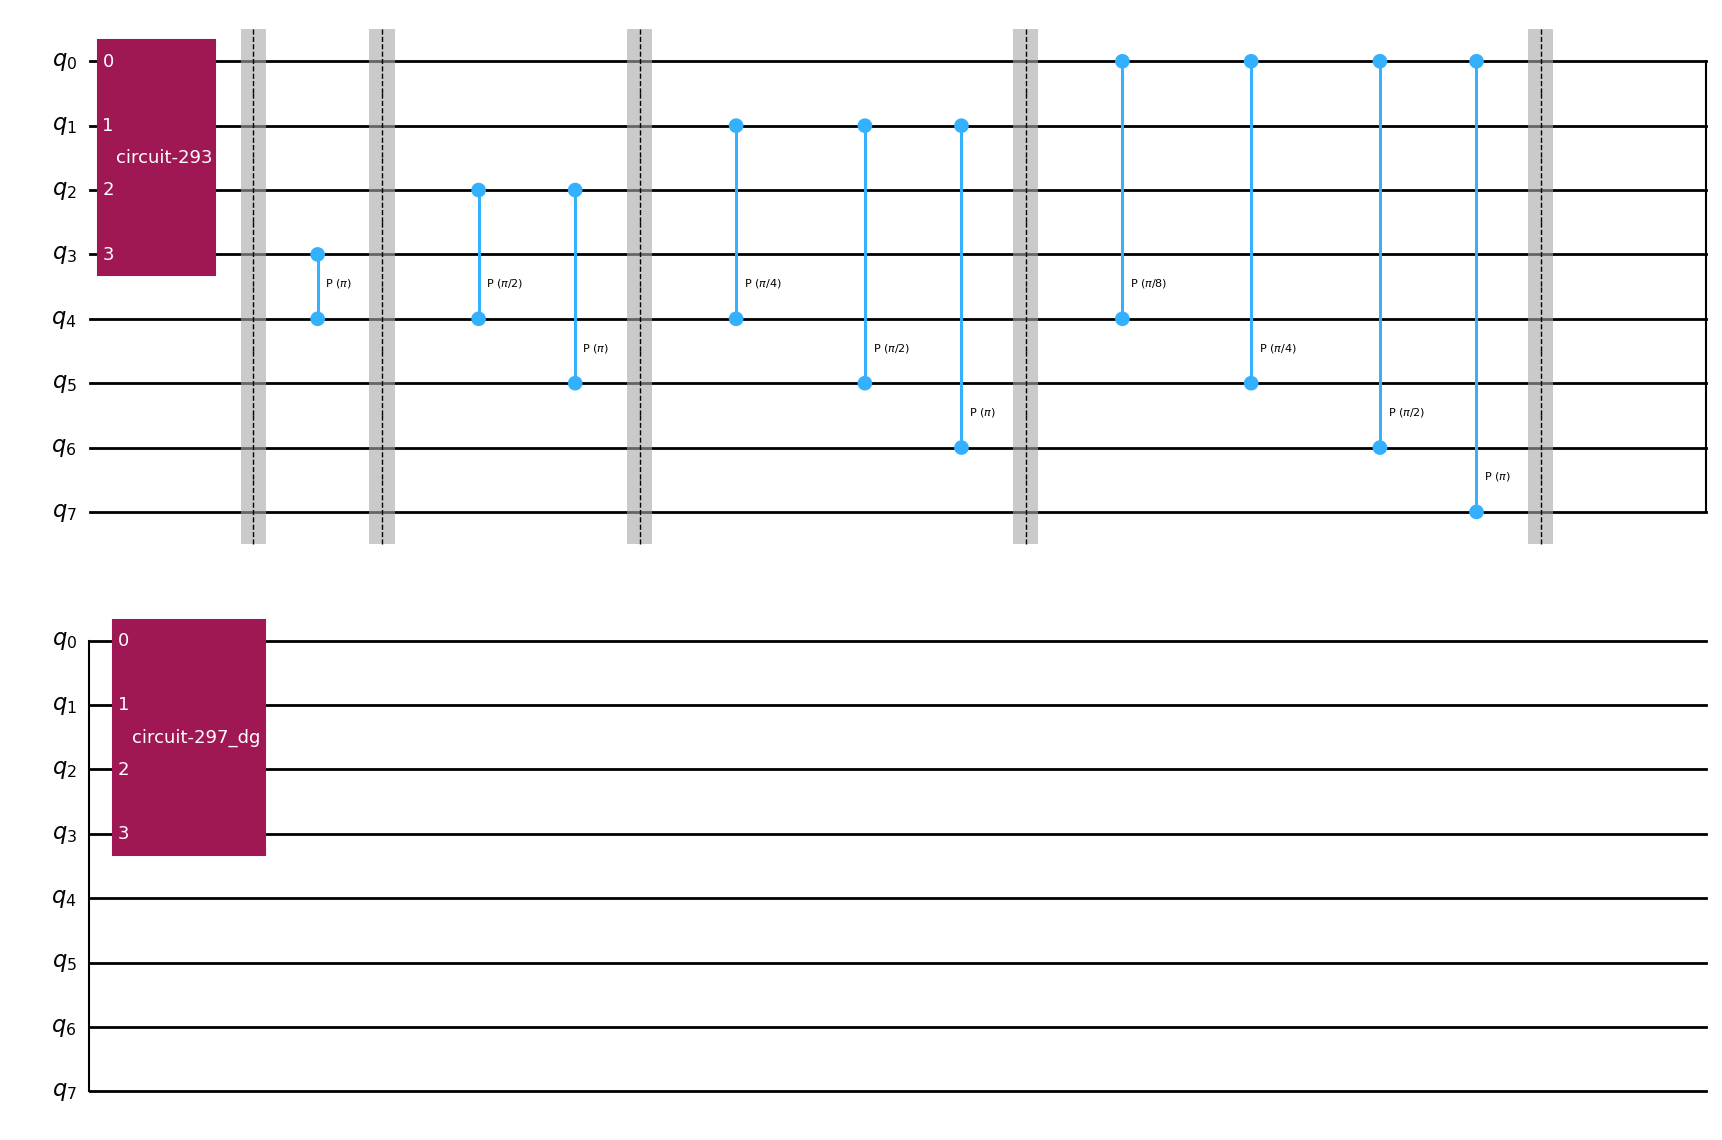

In [ ]:
n = 8
#qft = qft_n_qubits(QuantumCircuit(n//2), n//2, swaps = False, barrier = False)
qft = qft_n_qubits(QuantumCircuit(n//2), n//2)

#iqft = inverse_qft(QuantumCircuit(4), 4)

drqft = QuantumCircuit(n, name = 'Sum_draper')

#Implemento la QFT a los primeros 4 qubits
drqft.append(qft, [i for i in range(n//2)])
drqft.barrier()

for i in range(n//2 - 1, -1, -1): #Por a cada Ai
    #Empiezo i desde n//2 - 1, que es donde k = 0. 
    #Basicamente aplico las rotaciones al reves que el otro caso
    for j in range(0, n//2 - i, 1): #Por cada Bj
        drqft.cp(math.pi/2**(n//2 - 1 - i - j), drqft.qubits[j + n//2], drqft.qubits[i]) #El control es Bj (qubit j + 4) y el objetivo es Ai (qubit i)
    drqft.barrier()


#Le aplico la QFT inversa
#inverse_qft(drqft, n//2, swaps = False, barrier = False)
inverse_qft(drqft, n//2)

display(drqft.draw('mpl'))

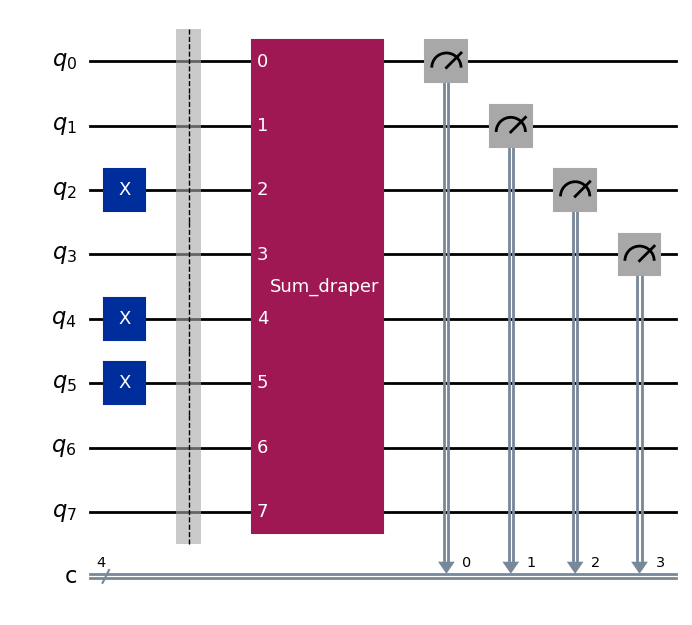

In [84]:
sum3 = QuantumCircuit(n, n//2)


sum3.x(n//2)
sum3.x(n//2 + 1)

sum3.x(2)

sum3.barrier()

sum3.append(drqft, sum3.qubits)



sum3.measure([i for i in range(n//2)], [i for i in range(n//2)])


display(sum3.draw('mpl'))

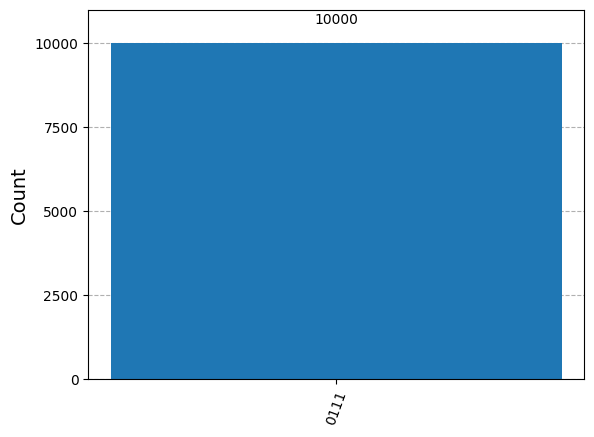

In [85]:
backend = Aer.get_backend('qasm_simulator')
tsum3 = transpile(sum3, backend = backend, optimization_level= 1)

job = backend.run(tsum3, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

Obtenemos el mismo resultado que en la QFT sin SWAPs, pues hemos aplicado las rotaciones correctamente considerando los SWAPs.
Ahora con la AQFT sería análogo el procedimiento

## Ejercicio 3
Ejecución en Backends reales el ejercicio 2

In [34]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

token = "19d55f84f8ce1c22426f6e7e52ef5540a66d0b2c1e8757645678c20a4cd97dd3c251e7c9bd1526c6e3bf66254700821a75e01af34d852c9ad1042157df76888a"

Sumador con QFT

Voy a probar sumar $b = 7$, $a = 2$. Debería salir $\ket{7}\ket{9}$

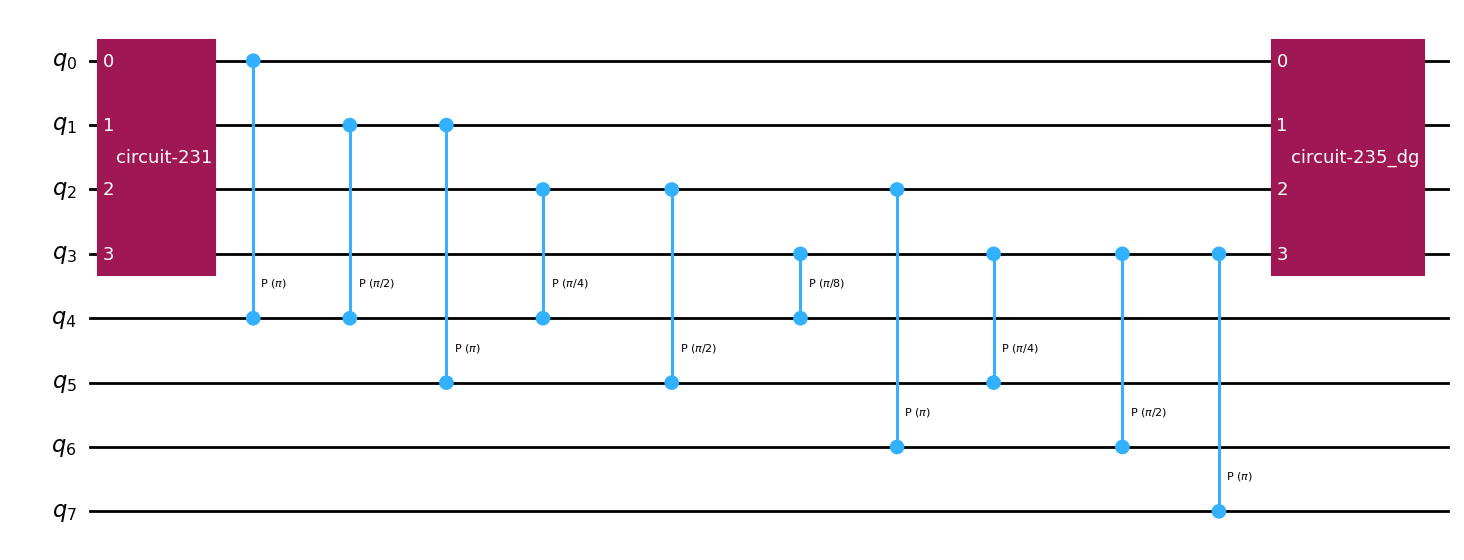

In [35]:
n = 8
qft = qft_n_qubits(QuantumCircuit(n//2), n//2, swaps = False, barrier = False)
#qft = qft_n_qubits(QuantumCircuit(n//2), n//2, swaps = False)

#iqft = inverse_qft(QuantumCircuit(4), 4)

drqft = QuantumCircuit(n, name = 'Sum_draper')

#Implemento la QFT a los primeros 4 qubits
drqft.append(qft, [i for i in range(n//2)])
#drqft.barrier()
for i in range(n//2): #Por a cada Ai
    for j in range(i + 1): #Por cada Bj que empieza en 4
        drqft.cp(math.pi/2**(i - j), drqft.qubits[j + n//2], drqft.qubits[i]) #El control es Bj (qubit j + 4) y el objetivo es Ai (qubit i)
    #drqft.barrier()


#Le aplico la QFT inversa
inverse_qft(drqft, n//2, swaps = False, barrier = False)
#inverse_qft(drqft, n//2, swaps = False)

display(drqft.draw('mpl'))

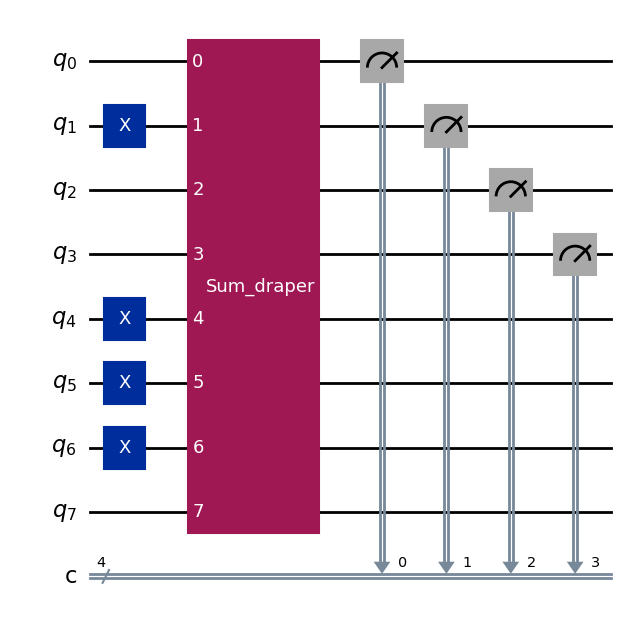

In [62]:
sum1 = QuantumCircuit(n, n//2)


sum1.x(n//2)
sum1.x(n//2 + 1)
sum1.x(n//2 + 2)

sum1.x(1)

#sum1.barrier()

sum1.append(drqft, sum1.qubits)

#sum1.measure_all()

sum1.measure([i for i in range(n//2)], [i for i in range(n//2)])

#display(drqft.decompose().draw('mpl'))
display(sum1.draw('mpl'))

Simulacion

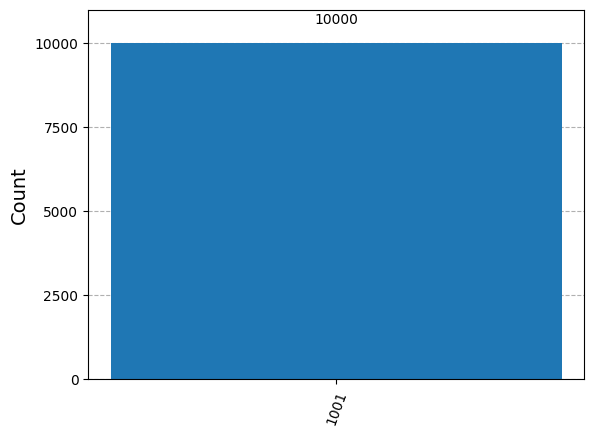

In [63]:
backend = Aer.get_backend('qasm_simulator')
tsum1 = transpile(sum1, backend = backend, optimization_level= 1)

job = backend.run(tsum1, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

In [64]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


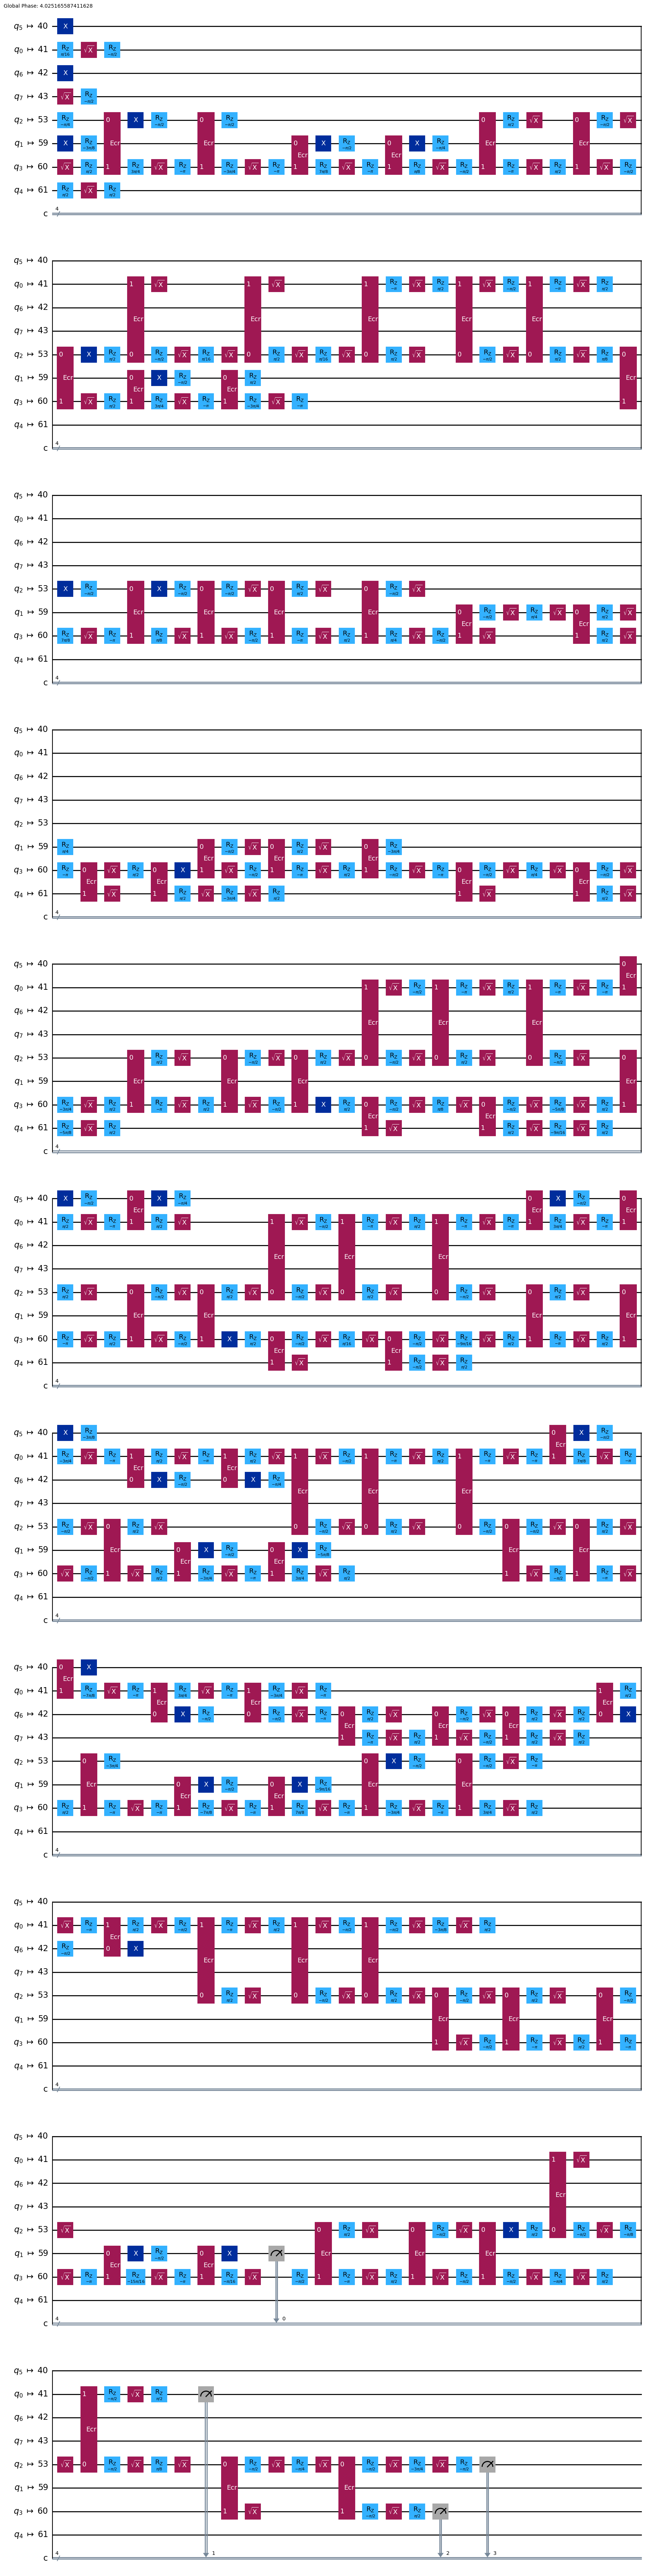

In [65]:
#service = QiskitRuntimeService(channel="ibm_quantum", token=token)
#backend = service.least_busy(simulator=False, operational=True)

backend = service.backend("ibm_kyiv")

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(sum1)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

In [66]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=10000)
print(f"job id: {job.job_id()}")
result = job.result()

job id: czm43m6p3xeg008h9bng


{'0010': 83, '1101': 732, '0101': 1859, '1111': 301, '0001': 990, '1001': 3131, '1011': 669, '0111': 892, '1010': 133, '1110': 54, '0100': 147, '0110': 95, '0011': 548, '1000': 160, '0000': 85, '1100': 121}


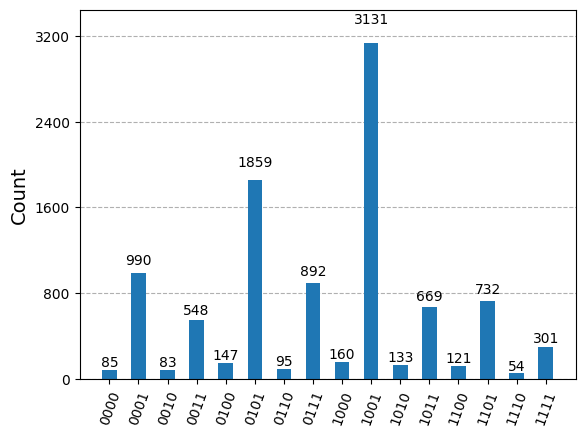

In [67]:
#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

Para probar el funcionamiento en backend real del sumador, lo he probado con el comutador "ibm_kyiv" que era el que, según las gráficas de IBM, menos errores presentaba en los qubits menores que 100 justo en el momento que he ejecutado el circuito.
Con ello me ha dado la siguiente gráfica: 
- He realizado 10.000 shots del circuito.
- Se observa que el valor predominante en las mediciones es $\ket{1001}$ que es el valor correcto de sumar $\ket{b} = \ket{0111}$ y $\ket{a} = \ket{0010}$.
- Pese a todo, me ha costado muchas ejecuciones para obtener este resultado de gráfico. Además, este ha sido la mejor ejecución que he obtenido y, aún así, hay muchos errores. La razón se deberá principalmente al ruido y también al gran tamaño del circuito al transpilarlo como se ve más arriba.

Sumador con AQFT

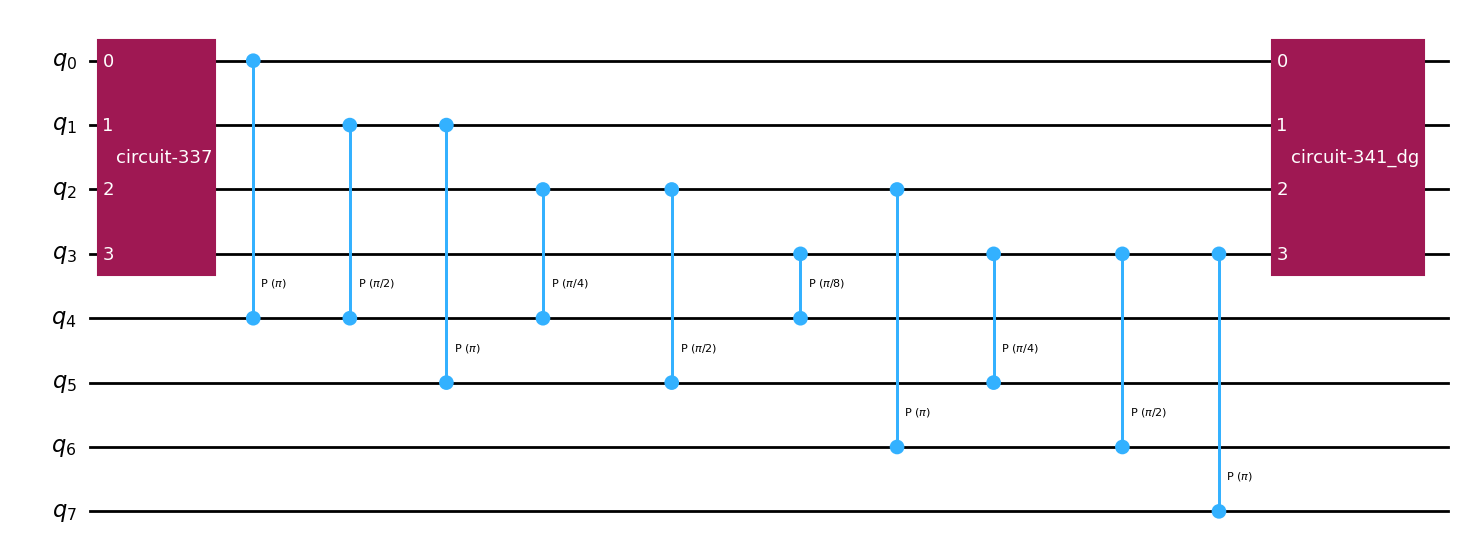

In [109]:
n = 8
aqft = aqft_NM(QuantumCircuit(n//2), n//2, 2, swaps = False, barrier = False)
#aqft = aqft_NM(QuantumCircuit(n//2), n//2, 2, swaps = False)
#iqft = inverse_qft(QuantumCircuit(4), 4)

draqft = QuantumCircuit(n, name = 'Sum_draper_AQFT')

#Implemento la AQFT a los primeros 4 qubits
draqft.append(aqft, [i for i in range(n//2)])
#draqft.barrier()
for i in range(n//2): #Por a cada Ai
    for j in range(i + 1): #Por cada Bj que empieza en 4
        draqft.cp(math.pi/2**(i - j), draqft.qubits[j + n//2], draqft.qubits[i]) #El control es Bj (qubit j + 4) y el objetivo es Ai (qubit i)
    #draqft.barrier()


#Le aplico la QFT inversa
inverse_aqft(draqft, n//2, 2, swaps = False, barrier = False)
#inverse_aqft(draqft, n//2, 2, swaps = False)

display(draqft.draw('mpl'))

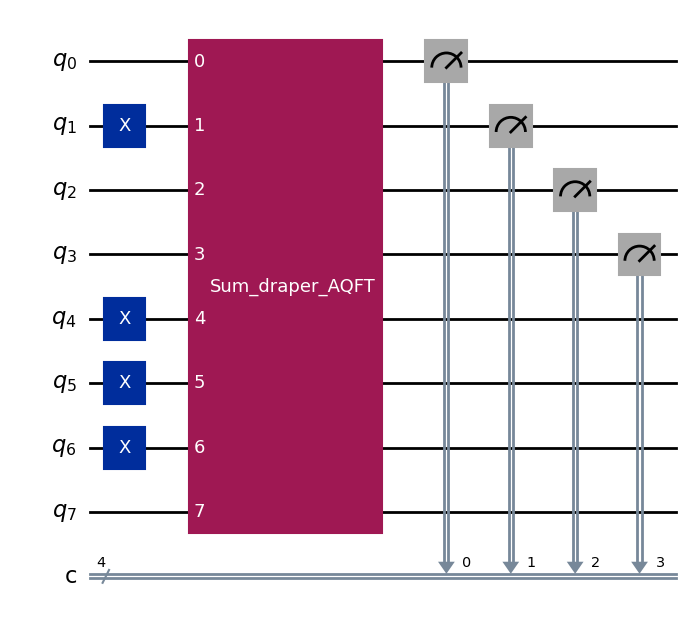

In [184]:
sum2 = QuantumCircuit(n, n//2)


sum2.x(n//2)
sum2.x(n//2 + 1)
sum2.x(n//2 + 2)

sum2.x(1)

#sum2.barrier()

sum2.append(draqft, sum2.qubits)

#sum2.measure_all()

sum2.measure([i for i in range(n//2)], [i for i in range(n//2)])


display(sum2.draw('mpl'))

Simulación

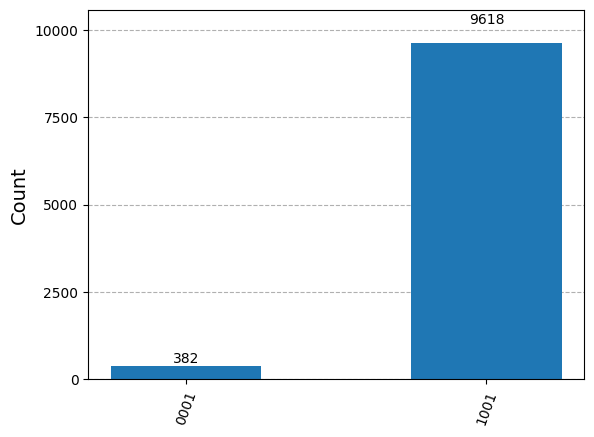

In [185]:
backend = Aer.get_backend('qasm_simulator')
tsum2 = transpile(sum2, backend = backend, optimization_level= 1)

job = backend.run(tsum2, shots = 10000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

En backend real

In [186]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


<IBMBackend('ibm_kyiv')>


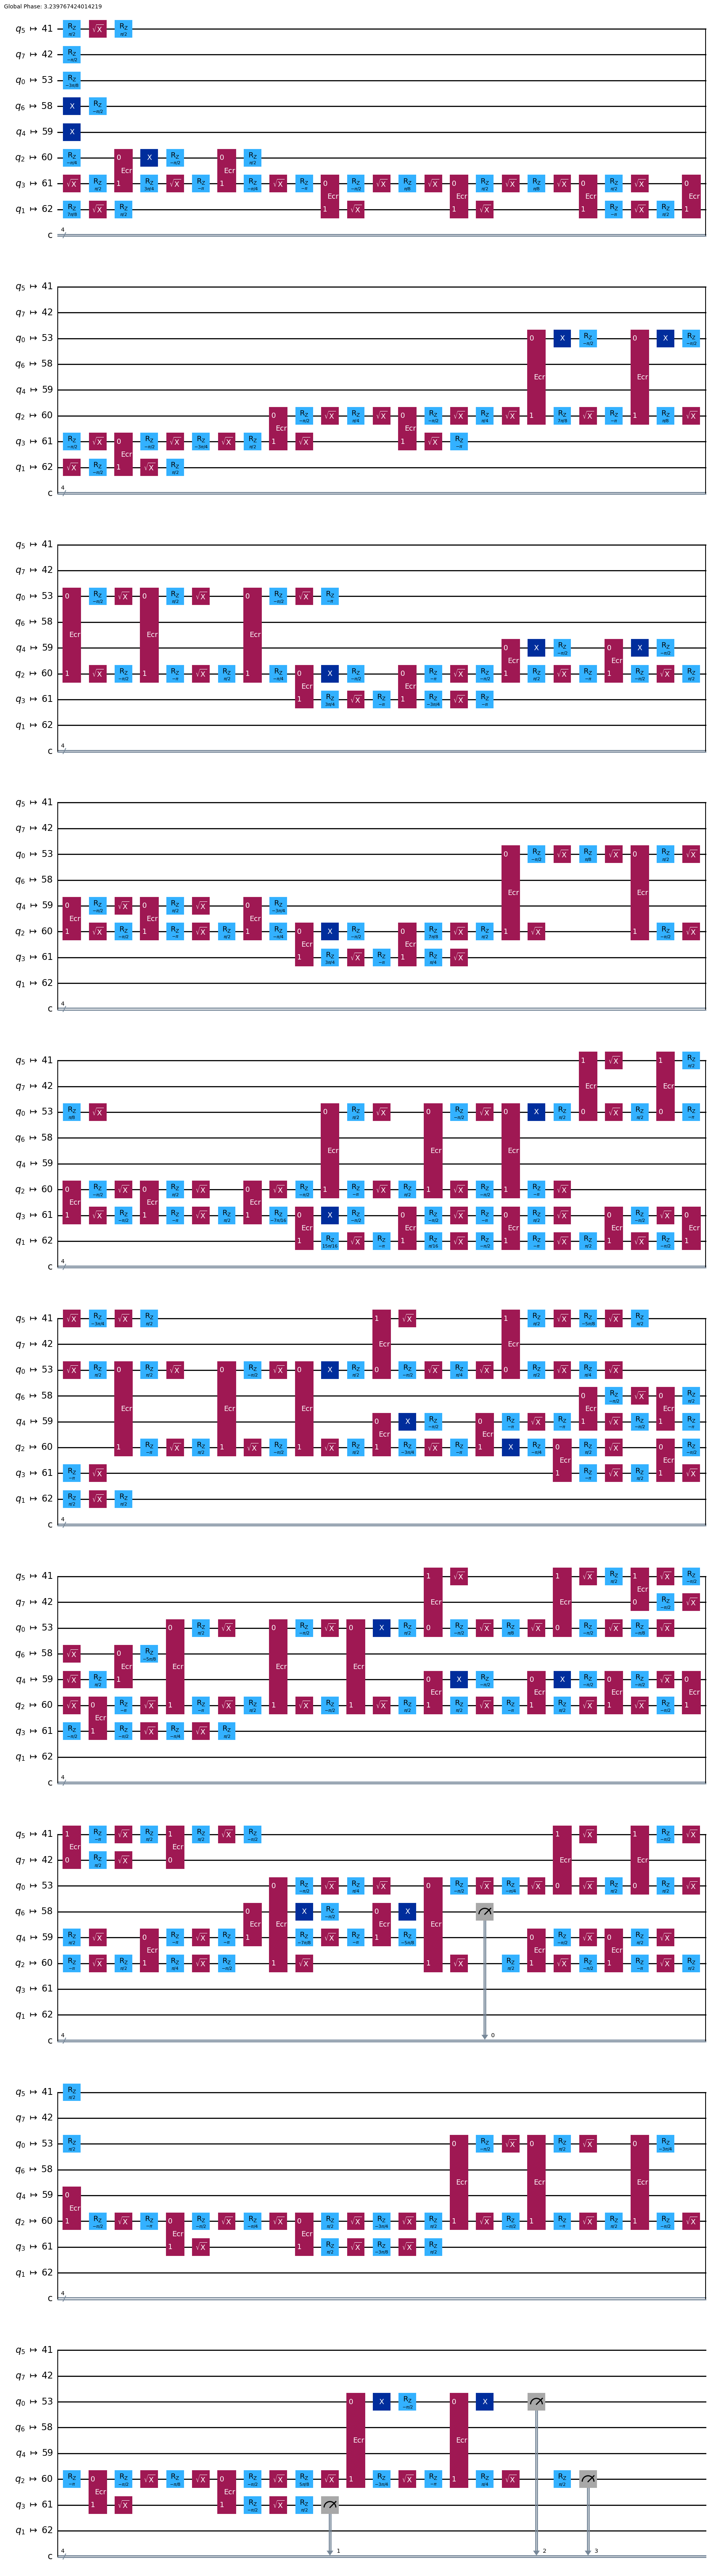

In [187]:
#service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.least_busy(simulator=False, operational=True)
#backend = service.backend("ibm_kyiv")
print(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(sum2)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

In [188]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=10000)
print(f"job id: {job.job_id()}")
result = job.result()

job id: czm5bjepj4bg008yzww0


{'1100': 77, '0001': 977, '1000': 148, '0111': 1290, '0010': 139, '1101': 622, '1011': 1532, '0011': 1317, '1010': 150, '1001': 1792, '0101': 1033, '0000': 92, '0100': 108, '1111': 553, '0110': 111, '1110': 59}


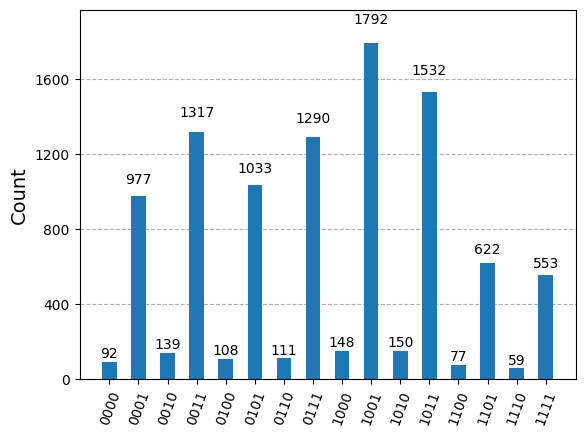

In [189]:
#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

Para estos circuitos he necesitado de más de 20 ejecuciones con 10.000 shots cada una para obtener un resultado similar al mostrado en la gráfica.

El valor medido que predomina en este caso ya ha sido el de la suma 7 + 2.\
No obstante, tenemos muchísimo error debido al momento que he ejecutado el circuito que ninguna QPU estaba funcionando muy bien respecto a los errores, y también por el gran tamaño y a la cantidad de puertas del circuito.